# Score-Based Generative Modeling


### Goals
This is a hitchhiker's guide to score-based generative models, a family of approaches based on [estimating gradients of the data distribution](https://arxiv.org/abs/1907.05600). They have obtained high-quality samples comparable to GANs (like below, figure from [this paper](https://arxiv.org/abs/2006.09011)) without requiring adversarial training, and are considered by some to be [the new contender to GANs](https://ajolicoeur.wordpress.com/the-new-contender-to-gans-score-matching-with-langevin-sampling/).

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Norm stats (0.31651841229383865, 0.3892599391249885)
torch.Size([16, 9, 120, 120])


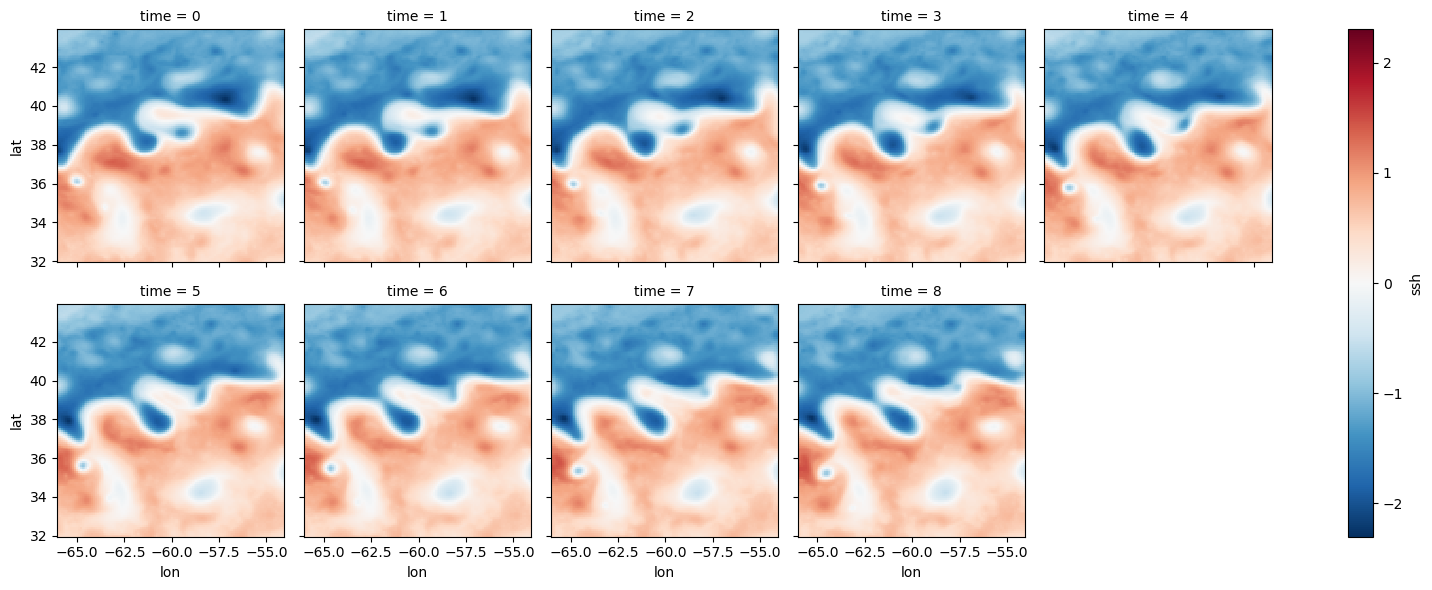

In [1]:
from data import *
import matplotlib.pyplot as plt
import itertools

lon_min = -66
lon_max = -54
#lon_max = -63
lat_min = 32
lat_max = 44
#lat_max = 35

#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
datamodule = BaseDataModule(input_da=load_altimetry_data("/Odyssey/private/m19beauc/IMT/data/natl_gf_w_5nadirs_swot.nc"),
                            domains={'train': {'time': slice('2013-02-24', '2013-09-30',)},
                                     'val': {'time': slice('2012-12-15', '2013-02-24',)},
                                     'test': {'time': slice('2012-10-01', '2012-12-20',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 120, 'lon': 120},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 16, 'num_workers': 0},
                            grad=False,
                            aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(9),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

# 1. Self attention mechanisms

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape 
        
        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape 

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head) 

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)
        
        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1) 
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf) 
        
        # Divide by d_k (Dim / H). 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head) 
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1) 
        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v
        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2) 
        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape) 
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output) 
        # (Batch_Size, Seq_Len, Dim)
        return output

class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads
    
    def forward(self, x, y):
        # x (latent): # (Batch_Size, Seq_Len_Q, Dim_Q)
        # y (context): # (Batch_Size, Seq_Len_KV, Dim_KV) = (Batch_Size, 77, 768)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        # Divide each embedding of Q into multiple heads such that d_heads * n_heads = Dim_Q
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)
        
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        q = self.q_proj(x)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        k = self.k_proj(y)
        # (Batch_Size, Seq_Len_KV, Dim_KV) -> (Batch_Size, Seq_Len_KV, Dim_Q)
        v = self.v_proj(y)

        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        q = q.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        k = k.view(interim_shape).transpose(1, 2) 
        # (Batch_Size, Seq_Len_KV, Dim_Q) -> (Batch_Size, Seq_Len_KV, H, Dim_Q / H) -> (Batch_Size, H, Seq_Len_KV, Dim_Q / H)
        v = v.view(interim_shape).transpose(1, 2) 
        
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) @ (Batch_Size, H, Dim_Q / H, Seq_Len_KV) -> (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = q @ k.transpose(-1, -2)
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight /= math.sqrt(self.d_head)
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV)
        weight = F.softmax(weight, dim=-1)
        # (Batch_Size, H, Seq_Len_Q, Seq_Len_KV) @ (Batch_Size, H, Seq_Len_KV, Dim_Q / H) -> (Batch_Size, H, Seq_Len_Q, Dim_Q / H)
        output = weight @ v
        # (Batch_Size, H, Seq_Len_Q, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, H, Dim_Q / H)
        output = output.transpose(1, 2).contiguous()
        # (Batch_Size, Seq_Len_Q, H, Dim_Q / H) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = output.view(input_shape)
        # (Batch_Size, Seq_Len_Q, Dim_Q) -> (Batch_Size, Seq_Len_Q, Dim_Q)
        output = self.out_proj(output)
        # (Batch_Size, Seq_Len_Q, Dim_Q)
        return output

# 2. VAE architectures

In [4]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)
    
    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)

        residue = x 

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)
        n, c, h, w = x.shape
        
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w)) 
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x = x.transpose(-1, -2)
        # Perform self-attention WITHOUT mask
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention(x)
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width) 
        x += residue

        # (Batch_Size, Features, Height, Width)
        return x 

class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)

        residue = x

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = self.groupnorm_1(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x = F.silu(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_1(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.groupnorm_2(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = F.silu(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x = self.conv_2(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return x + self.residual_layer(residue)

    
class VAE_Encoder(nn.Sequential):
    def __init__(self, in_channels=9, out_channels=28):
        super().__init__(
            # (Batch_Size, Channel, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),  
             # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128),
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(128, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0), 
            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(256, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.GroupNorm(32, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.SiLU(), 

            # Because the padding=1, it means the width and height will increase by 2
            # Out_Height = In_Height + Padding_Top + Padding_Bottom
            # Out_Width = In_Width + Padding_Left + Padding_Right
            # Since padding = 1 means Padding_Top = Padding_Bottom = Padding_Left = Padding_Right = 1,
            # Since the Out_Width = In_Width + 2 (same for Out_Height), it will compensate for the Kernel size of 3
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8). 
            nn.Conv2d(512, out_channels, kernel_size=3, padding=1), 

            # (Batch_Size, 8, Height / 8, Width / 8) -> (Batch_Size, 8, Height / 8, Width / 8)
            nn.Conv2d(out_channels, out_channels, kernel_size=1, padding=0), 
        )

    def forward(self, x):
        # x: (Batch_Size, Channel, Height, Width)
        # noise: (Batch_Size, 4, Height / 8, Width / 8)

        for module in self:

            if getattr(module, 'stride', None) == (2, 2):  # Padding at downsampling should be asymmetric (see #8)
                # Pad: (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom).
                # Pad with zeros on the right and bottom.
                # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Channel, Height + Padding_Top + Padding_Bottom, Width + Padding_Left + Padding_Right) = (Batch_Size, Channel, Height + 1, Width + 1)
                x = F.pad(x, (0, 1, 0, 1))
            
            x = module(x)
        # (Batch_Size, 8, Height / 8, Width / 8) -> two tensors of shape (Batch_Size, 4, Height / 8, Width / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)
        # Clamp the log variance between -30 and 20, so that the variance is between (circa) 1e-14 and 1e8. 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        log_variance = torch.clamp(log_variance, -30, 20)
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        variance = log_variance.exp()
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        stdev = variance.sqrt()
        
        # reparametrization trick: Transform N(0, 1) -> N(mean, stdev) 
        # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
        noise = torch.Tensor(np.random.normal(size=mean.size(), scale=1.0)).to(x.device)
        x = mean + stdev * noise
        
        # Scale by a constant
        # Constant taken from: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/configs/stable-diffusion/v1-inference.yaml#L17C1-L17C1
        x *= 0.18215
        
        return x, mean, log_variance

class VAE_Decoder(nn.Sequential):
    def __init__(self,in_channels=14, out_channels=9):
        super().__init__(
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 4, Height / 8, Width / 8)
            nn.Conv2d(in_channels, 4, kernel_size=1, padding=0),
            # (Batch_Size, 4, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            nn.Conv2d(4, 512, kernel_size=3, padding=1),   
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_AttentionBlock(512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 8, Width / 8)
            VAE_ResidualBlock(512, 512), 
            # Repeats the rows and columns of the data by scale_factor (like when you resize an image by doubling its size).
            # (Batch_Size, 512, Height / 8, Width / 8) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Upsample(scale_factor=2),
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 4, Width / 4)
            VAE_ResidualBlock(512, 512), 
            # (Batch_Size, 512, Height / 4, Width / 4) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Upsample(scale_factor=2), 
            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 512, Height / 2, Width / 2)
            nn.Conv2d(512, 512, kernel_size=3, padding=1), 
            # (Batch_Size, 512, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(512, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 2, Width / 2)
            VAE_ResidualBlock(256, 256), 
            # (Batch_Size, 256, Height / 2, Width / 2) -> (Batch_Size, 256, Height, Width)
            nn.Upsample(scale_factor=2), 
            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 256, Height, Width)
            nn.Conv2d(256, 256, kernel_size=3, padding=1), 
            # (Batch_Size, 256, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(256, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            VAE_ResidualBlock(128, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.GroupNorm(32, 128), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 128, Height, Width)
            nn.SiLU(), 
            # (Batch_Size, 128, Height, Width) -> (Batch_Size, 3, Height, Width)
            nn.Conv2d(128, out_channels, kernel_size=3, padding=1), 
        )

    def forward(self, x):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        
        # Remove the scaling added by the Encoder.
        x /= 0.18215

        for module in self:
            x = module(x)

        # (Batch_Size, 3, Height, Width)
        return x

## Introduction

### Score and Score-Based Models
Given a probablity density function $p(\mathbf{x})$, we define the *score* as $$\nabla_\mathbf{x} \log p(\mathbf{x}).$$ As you might guess, score-based generative models are trained to estimate $\nabla_\mathbf{x} \log p(\mathbf{x})$. Unlike likelihood-based models such as flow models or autoregressive models, score-based models do not have to be normalized and are easier to parameterize. For example, consider a non-normalized statistical model $p_\theta(\mathbf{x}) = \frac{e^{-E_\theta(\mathbf{x})}}{Z_\theta}$, where $E_\theta(\mathbf{x}) \in \mathbb{R}$ is called the energy function and $Z_\theta$ is an unknown normalizing constant that makes $p_\theta(\mathbf{x})$ a proper probability density function. The energy function is typically parameterized by a flexible neural network. When training it as a likelihood model, we need to know the normalizing constant $Z_\theta$ by computing complex high-dimensional integrals, which is typically intractable. In constrast, when computing its score, we obtain $\nabla_\mathbf{x} \log p_\theta(\mathbf{x}) = -\nabla_\mathbf{x} E_\theta(\mathbf{x})$ which does not require computing the normalizing constant $Z_\theta$.

In fact, any neural network that maps an input vector $\mathbf{x} \in \mathbb{R}^d$ to an output vector $\mathbf{y} \in \mathbb{R}^d$ can be used as a score-based model, as long as the output and input have the same dimensionality. This yields huge flexibility in choosing model architectures.

### Perturbing Data with a Diffusion Process

In order to generate samples with score-based models, we need to consider a [diffusion process](https://en.wikipedia.org/wiki/Diffusion_process) that corrupts data slowly into random noise. Scores will arise when we reverse this diffusion process for sample generation. You will see this later in the notebook.

A diffusion process is a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process#:~:text=A%20stochastic%20or%20random%20process%20can%20be%20defined%20as%20a,an%20element%20in%20the%20set.) similar to [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). Their paths are like the trajectory of a particle submerged in a flowing fluid, which moves randomly due to unpredictable collisions with other particles. Let $\{\mathbf{x}(t) \in \mathbb{R}^d \}_{t=0}^T$ be a diffusion process, indexed by the continuous time variable $t\in [0,T]$. A diffusion process is governed by a stochastic differential equation (SDE), in the following form

\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}

where $\mathbf{f}(\cdot, t): \mathbb{R}^d \to \mathbb{R}^d$ is called the *drift coefficient* of the SDE, $g(t) \in \mathbb{R}$ is called the *diffusion coefficient*, and $\mathbf{w}$ represents the standard Brownian motion. You can understand an SDE as a stochastic generalization to ordinary differential equations (ODEs). Particles moving according to an SDE not only follows the deterministic drift $\mathbf{f}(\mathbf{x}, t)$, but are also affected by the random noise coming from $g(t) d\mathbf{w}$. From now on, we use $p_t(\mathbf{x})$ to denote the distribution of $\mathbf{x}(t)$.

For score-based generative modeling, we will choose a diffusion process such that $\mathbf{x}(0) \sim p_0$, and $\mathbf{x}(T) \sim p_T$. Here $p_0$ is the data distribution where we have a dataset of i.i.d. samples, and $p_T$ is the prior distribution that has a tractable form and easy to sample from. The noise perturbation by the diffusion process is large enough to ensure $p_T$ does not depend on $p_0$.

### Reversing the Diffusion Process Yields Score-Based Generative Models
By starting from a sample from the prior distribution $p_T$ and reversing the diffusion process, we will be able to obtain a sample from the data distribution $p_0$. Crucially, the reverse process is a diffusion process running backwards in time. It is given by the following reverse-time SDE

\begin{align}
  d\mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g^2(t)\nabla_{\mathbf{x}}\log p_t(\mathbf{x})] dt + g(t) d\bar{\mathbf{w}},
\end{align}

where $\bar{\mathbf{w}}$ is a Brownian motion in the reverse time direction, and $dt$ represents an infinitesimal negative time step. This reverse SDE can be computed once we know the drift and diffusion coefficients of the forward SDE, as well as the score of $p_t(\mathbf{x})$ for each $t\in[0, T]$.

The overall intuition of score-based generative modeling with SDEs can be summarized in the illustration below

![sde schematic](https://drive.google.com/uc?id=1Ptvb790eQRYMHLnDGBeYZK9A2cF-JMEP)


### Score Estimation

Based on the above intuition, we can use the time-dependent score function $\nabla_\mathbf{x} \log p_t(\mathbf{x})$ to construct the reverse-time SDE, and then solve it numerically to obtain samples from $p_0$ using samples from a prior distribution $p_T$. We can train a time-dependent score-based model $s_\theta(\mathbf{x}, t)$ to approximate $\nabla_\mathbf{x} \log p_t(\mathbf{x})$, using the following weighted sum of [denoising score matching](http://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf) objectives.

\begin{align}
\min_\theta \mathbb{E}_{t\sim \mathcal{U}(0, T)} [\lambda(t) \mathbb{E}_{\mathbf{x}(0) \sim p_0(\mathbf{x})}\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2]],
\end{align}
where $\mathcal{U}(0,T)$ is a uniform distribution over $[0, T]$, $p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$ denotes the transition probability from $\mathbf{x}(0)$ to $\mathbf{x}(t)$, and $\lambda(t) \in \mathbb{R}_{>0}$ denotes a positive weighting function.

In the objective, the expectation over $\mathbf{x}(0)$ can be estimated with empirical means over data samples from $p_0$. The expectation over $\mathbf{x}(t)$ can be estimated by sampling from $p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$, which is efficient when the drift coefficient $\mathbf{f}(\mathbf{x}, t)$ is affine. The weight function $\lambda(t)$ is typically chosen to be inverse proportional to $\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) \|_2^2]$.



### Time-Dependent Score-Based Model

There are no restrictions on the network architecture of time-dependent score-based models, except that their output should have the same dimensionality as the input, and they should be conditioned on time.

Several useful tips on architecture choice:
* It usually performs well to use the [U-net](https://arxiv.org/abs/1505.04597) architecture as the backbone of the score network $s_\theta(\mathbf{x}, t)$,

* We can incorporate the time information via [Gaussian random features](https://arxiv.org/abs/2006.10739). Specifically, we first sample $\omega \sim \mathcal{N}(\mathbf{0}, s^2\mathbf{I})$ which is subsequently fixed for the model (i.e., not learnable). For a time step $t$, the corresponding Gaussian random feature is defined as
\begin{align}
  [\sin(2\pi \omega t) ; \cos(2\pi \omega t)],
\end{align}
where $[\vec{a} ; \vec{b}]$ denotes the concatenation of vector $\vec{a}$ and $\vec{b}$. This Gaussian random feature can be used as an encoding for time step $t$ so that the score network can condition on $t$ by incorporating this encoding. We will see this further in the code.

* We can rescale the output of the U-net by $1/\sqrt{\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) \|_2^2]}$. This is because the optimal $s_\theta(\mathbf{x}(t), t)$ has an $\ell_2$-norm close to $\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))]\|_2$, and the rescaling helps capture the norm of the true score. Recall that the training objective contains sums of the form
\begin{align*}
\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2].
\end{align*}
Therefore, it is natural to expect that the optimal score model $s_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}(t)} \log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$.

* Use [exponential moving average](https://discuss.pytorch.org/t/how-to-apply-exponential-moving-average-decay-for-variables/10856/3) (EMA) of weights when sampling. This can greatly improve sample quality, but requires slightly longer training time, and requires more work in implementation. We do not include this in this tutorial, but highly recommend it when you employ score-based generative modeling to tackle more challenging real problems.

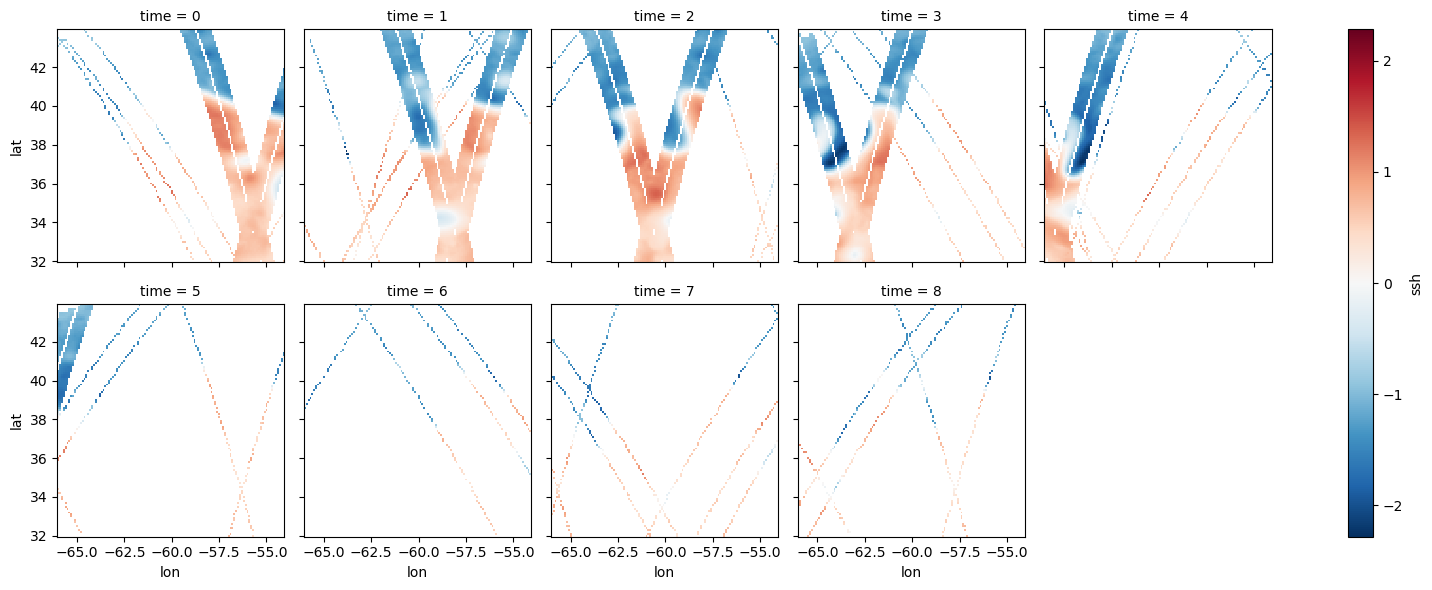

In [5]:
class NLpObs(torch.nn.Module):

    def __init__(self, noise=1e-3):
        super(NLpObs, self).__init__()
        self.noise = noise

    def forward(self, x, y):

        n_b, n_t, n_x, n_y = y.shape
        mask = y.isfinite()
        nb_nodes = n_x*n_y

        NLobs = list()
        for i in range(n_b):
            obs = y[i][mask[i]]
            state = x[i][mask[i]]
            innov = obs-state
            # define sparse observation operator
            row = []
            col = []
            idx = 0
            for k in range(n_t):
                idD = torch.where(torch.flatten(mask[i,k,:,:])!=0.)[0]
                if len(idD)>0:
                    row.extend( (idx + np.arange(0,len(idD))).tolist() )
                    col.extend( ((k*nb_nodes)+idD).tolist() )
                    idx = idx + len(idD)
            val = np.ones(len(row))
            nb_obs = len(torch.where(torch.flatten(mask[i])!=0.)[0])
            opH = torch.sparse.FloatTensor(torch.LongTensor([row,col]),
                                         torch.FloatTensor(val),
                                         torch.Size([nb_obs,n_t*nb_nodes])).to(device)

            grad_obs = -1.*torch.sparse.mm(torch.transpose(opH,0,1),(1./self.noise)*torch.unsqueeze(innov,dim=1))
            NLobs.append(torch.reshape(grad_obs,(n_t,n_y,n_x)))

        NLobs = -1.*torch.stack(NLobs)

        return NLobs

grad_obs = NLpObs(noise=1e-1)
my_sample = next(itertools.islice(data_loader, k, None))

y = my_sample[0]
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),y[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=5)
plt.show()

In [6]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    ret = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
    return ret

class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, 
               latent_channels = 9,
               channels=[32, 64, 128, 256], embed_dim=256, cond=False):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    self.latent_channels = latent_channels
    self.cond = cond
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(latent_channels, channels[0], 3, stride=1, padding=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(int(np.floor(channels[0]/8)), num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(channels[0], num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(channels[0], num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(channels[0], num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(channels[0], num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, padding=1, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(channels[0], num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, padding=1, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(channels[0], num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], latent_channels, 3, stride=1, padding=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    
    self.norm = torch.nn.Parameter(torch.tensor([1.]))
  
  # !! add y to try stacked conditioning
  def forward(self, x, y, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    if self.cond==True:
        h1 = self.conv1(torch.cat([x,y],dim=1))  
    else:
        h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h[:,:,:15,:15], h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    
    # add the conditioning
    if self.cond:
        grado = grad_obs(x,y)#*self.norm
        h+=grado
        
    return h

## Training with Weighted Sum of Denoising Score Matching Objectives

Now let's get our hands dirty on training. First of all, we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
In this case,
\begin{align*}
p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) = \mathcal{N}\bigg(\mathbf{x}(t); \mathbf{x}(0), \frac{1}{2\log \sigma}(\sigma^{2t} - 1) \mathbf{I}\bigg)
\end{align*}
and we can choose the weighting function $\lambda(t) = \frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$.

When $\sigma$ is large, the prior distribution, $p_{t=1}$ is
\begin{align*}
\int p_0(\mathbf{y})\mathcal{N}\bigg(\mathbf{x}; \mathbf{y}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg) d \mathbf{y} \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2 \log \sigma}(\sigma^2 - 1)\mathbf{I}\bigg),
\end{align*}
which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\frac{1}{2 \log \sigma}(\sigma^{2t} - 1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_0$ to a simple Gaussian distribution $p_1$.

In [7]:
#@title Set up the SDE

import functools
device = 'cuda'
  
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

class Diffusion(nn.Module):
    def __init__(self,latent_channels, sigma, cond=False):
        super().__init__()
        self.cond = cond
        self.marginal_prob_std = functools.partial(marginal_prob_std, sigma=sigma)
        self.diffusion_coeff = functools.partial(diffusion_coeff, sigma=sigma)
        self.score_model = ScoreNet(latent_channels=latent_channels,
                              marginal_prob_std=self.marginal_prob_std,
                              cond=self.cond).to(device)
  
    def score_loss(self, z, y, eps=1e-5):
        """The loss function for training score-based generative models
        Args:
        model: A PyTorch model instance that represents a
        time-dependent score-based model.
        x: A mini-batch of training data.
        marginal_prob_std: A function that gives the standard deviation of
        the perturbation kernel.
        eps: A tolerance value for numerical stability.
        """
        random_t = torch.rand(z.shape[0], device=x.device) * (1. - eps) + eps
        eps = torch.randn_like(x).to(device)
        std = self.marginal_prob_std(random_t)
        perturbed_z = z + eps * std[:, None, None, None]
        score = self.score_model(perturbed_z, y, random_t)
        loss = torch.mean(torch.sum((score * std[:, None, None, None] + eps)**2, dim=(1,2,3)))
        return loss

    def forward(self,
                z,
                sampler='Euler_Maruyama_sampler',
                batch_size=4,
                num_steps=100):
        
        latent_space_dim = z.size()
        
        latent_estim = eval(sampler)(self.score_model,
                          self.marginal_prob_std,
                          self.diffusion_coeff,
                          latent_space_dim,
                          y,
                          batch_size=batch_size,
                          num_steps=num_steps,
                          device=device) 
        return latent_estim
        
# instantiate the UNet score-based model
#score_model = torch.nn.DataParallel(ScoreNet(latent_channels=25,marginal_prob_std=marginal_prob_std_fn,cond=False))
#score_model = score_model.to(device)

## Sampling with Numerical SDE Solvers
Recall that for any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt + g(t) d\mathbf{w},
\end{align*}
the reverse-time SDE is given by
\begin{align*}
d \mathbf{x} = [\mathbf{f}(\mathbf{x}, t) - g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})] dt + g(t) d \bar{\mathbf{w}}.
\end{align*}
Since we have chosen the forward SDE to be
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}
The reverse-time SDE is given by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} \nabla_\mathbf{x} \log p_t(\mathbf{x}) dt + \sigma^t d \bar{\mathbf{w}}.
\end{align*}
To sample from our time-dependent score-based model $s_\theta(\mathbf{x}, t)$, we first draw a sample from the prior distribution $p_1 \approx \mathbf{N}\bigg(\mathbf{x}; \mathbf{0}, \frac{1}{2}(\sigma^{2} - 1) \mathbf{I}\bigg)$, and then solve the reverse-time SDE with numerical methods.

In particular, using our time-dependent score-based model, the reverse-time SDE can be approximated by
\begin{align*}
d\mathbf{x} = -\sigma^{2t} s_\theta(\mathbf{x}, t) dt + \sigma^t d \bar{\mathbf{w}}
\end{align*}

Next, one can use numerical methods to solve for the reverse-time SDE, such as the [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) approach. It is based on a simple discretization to the SDE, replacing $dt$ with $\Delta t$ and $d \mathbf{w}$ with $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, g^2(t) \Delta t \mathbf{I})$. When applied to our reverse-time SDE, we can obtain the following iteration rule
\begin{align}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + \sigma^{2t} s_\theta(\mathbf{x}_t, t)\Delta t + \sigma^t\sqrt{\Delta t} \mathbf{z}_t,
\end{align}
where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

In [8]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)
from tqdm.autonotebook import tqdm

def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           latent_space_dim,
                           y,
                           batch_size=64,
                           num_steps=100,
                           device='cuda',
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(latent_space_dim, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  tqdm_time_steps = tqdm(time_steps)    
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm_time_steps:
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, y, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

## Sampling with Predictor-Corrector Methods

Aside from generic numerical SDE solvers, we can leverage special properties of our reverse-time SDE for better solutions. Since we have an estimate of the score of $p_t(\mathbf{x}(t))$ via the score-based model, i.e., $s_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}(t)} \log p_t(\mathbf{x}(t))$, we can leverage score-based MCMC approaches, such as Langevin MCMC, to correct the solution obtained by numerical SDE solvers.

Score-based MCMC approaches can produce samples from a distribution $p(\mathbf{x})$ once its score $\nabla_\mathbf{x} \log p(\mathbf{x})$ is known. For example, Langevin MCMC operates by running the following iteration rule for $i=1,2,\cdots, N$:
\begin{align*}
\mathbf{x}_{i+1} = \mathbf{x}_{i} + \epsilon \nabla_\mathbf{x} \log p(\mathbf{x}_i) + \sqrt{2\epsilon} \mathbf{z}_i,
\end{align*}
where $\mathbf{z}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, $\epsilon > 0$ is the step size, and $\mathbf{x}_1$ is initialized from any prior distribution $\pi(\mathbf{x}_1)$. When $N\to\infty$ and $\epsilon \to 0$, the final value $\mathbf{x}_{N+1}$ becomes a sample from $p(\mathbf{x})$ under some regularity conditions. Therefore, given $s_\theta(\mathbf{x}, t) \approx \nabla_\mathbf{x} \log p_t(\mathbf{x})$, we can get an approximate sample from $p_t(\mathbf{x})$ by running several steps of Langevin MCMC, replacing $\nabla_\mathbf{x} \log p_t(\mathbf{x})$ with $s_\theta(\mathbf{x}, t)$ in the iteration rule.

Predictor-Corrector samplers combine both numerical solvers for the reverse-time SDE and the Langevin MCMC approach. In particular, we first apply one step of numerical SDE solver to obtain $\mathbf{x}_{t-\Delta t}$ from $\mathbf{x}_t$, which is called the "predictor" step. Next, we apply several steps of Langevin MCMC to refine $\mathbf{x}_t$, such that $\mathbf{x}_t$ becomes a more accurate sample from $p_{t-\Delta t}(\mathbf{x})$. This is the "corrector" step as the MCMC helps reduce the error of the numerical SDE solver.

In [9]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-3,
               cond=False):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 15, 240, 240, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  tqdm_time_steps = tqdm(time_steps)  
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm_time_steps:
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)   
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      if cond:
        x_mean = x + (g**2)[:, None, None, None] * (score_model(x, batch_time_step) + grado) * step_size
      else:
        x_mean = x + (g**2)[:, None, None, None] * (score_model(x, batch_time_step)) * step_size  
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    # The last step does not include any noise
    return x_mean

test = False
if test:
  # test
  ckpt = torch.load('ckpt/ckpt.pth', map_location=device)
  score_model.load_state_dict(ckpt)
  x_estim = pc_sampler(score_model,
                           marginal_prob_std_fn,
                           diffusion_coeff_fn,
                           batch_size=4,
                           num_steps=num_steps,
                           snr=signal_to_noise_ratio,
                           device=device,
                           eps=1e-3) 

  xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_estim.detach().cpu()[0])},
           coords={'time':np.arange(15),
                   'lon':np.arange(-66, -54, 0.05),
                   'lat':np.arange(32, 44, 0.05)}).ssh.plot(col='time',col_wrap=5)
  plt.show()

## Sampling with Numerical ODE Solvers

For any SDE of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) d t + g(t) d \mathbf{w},
\end{align*}
there exists an associated ordinary differential equation (ODE)
\begin{align*}
d \mathbf{x} = \bigg[\mathbf{f}(\mathbf{x}, t) - \frac{1}{2}g(t)^2 \nabla_\mathbf{x} \log p_t(\mathbf{x})\bigg] dt,
\end{align*}
such that their trajectories have the same mariginal probability density $p_t(\mathbf{x})$. Therefore, by solving this ODE in the reverse time direction, we can sample from the same distribution as solving the reverse-time SDE.
We call this ODE the *probability flow ODE*.

Below is a schematic figure showing how trajectories from this probability flow ODE differ from SDE trajectories, while still sampling from the same distribution.
![SDE and ODE](https://drive.google.com/uc?id=1CGFbtY2mCjlIY8pjvoGevfa_32d4b1dj)

Therefore, we can start from a sample from $p_T$, integrate the ODE in the reverse time direction, and then get a sample from $p_0$. In particular, for the SDE in our running example, we can integrate the following ODE from $t=T$ to $0$ for sample generation
\begin{align*}
d\mathbf{x} =  -\frac{1}{2}\sigma^{2t} s_\theta(\mathbf{x}, t) dt.
\end{align*}
This can be done using many black-box ODE solvers provided by packages such as `scipy`.

In [10]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                y,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 9, 120, 120, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, y, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    y = torch.tensor(y, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, y, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, y, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x

# Latent Diffusion Model (VAE + Diffusion)

In [11]:
class LDM(nn.Sequential):
    def __init__(self,in_channels=9, out_channels=28, sigma=5.0):
        super().__init__()
        self.encoder = VAE_Encoder(in_channels, out_channels).to(device)
        self.decoder = VAE_Decoder(out_channels//2,in_channels).to(device)
        self.diffusion = Diffusion(out_channels//2, sigma=sigma, cond=False).to(device)
        
    def vae_loss(self, x, x_hat, mean, log_var, wKL=.01):
        reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
        grad_loss = nn.functional.mse_loss(sobel(x_hat), sobel(x), reduction='mean')
        KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
        return reproduction_loss + 10*grad_loss + wKL*KLD, reproduction_loss, KLD
    
    def forward(self, x, diffusion=False):
        # encoder
        z, mean, log_var = self.encoder(x)
        # diffusion in latent space
        if diffusion:
            # diff
            z2 = self.diffusion(z)
            # decoder
            x_hat = self.decoder(z2)
        else:
            # decoder
            x_hat = self.decoder(z)
        return x_hat
        
ldm = LDM(in_channels=9, out_channels=50)

# Training

In [21]:
ckpt = torch.load('ckpt/ckpt.pth', map_location=device)
ldm.load_state_dict(ckpt)

<All keys matched successfully>

In [26]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm
from kornia.filters import sobel

n_epochs =  1000#@param {'type':'integer'}
## learning rate
lr = 1e-4 #@param {'type':'number'}

optimizer = Adam(
        [
            {"params": ldm.encoder.parameters(), "lr": lr},
            {"params": ldm.decoder.parameters(), "lr": lr},
            #{"params": ldm.diffusion.parameters(), "lr": lr},
        ],
    )

tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for y, x in data_loader:
    #x = sobel(x).to(device)
    #y = sobel(y).nan_to_num().to(device)
    x = x.to(device)
    y = y.nan_to_num().to(device)
    z, mean, log_var = ldm.encoder(x)
    x_hat = ldm.decoder(z)
    loss_vae, rec, KL = ldm.vae_loss(x, x_hat, mean, log_var, wKL=0.00001)
    #loss_diff = ldm.diffusion.score_loss(z, y)
    loss = loss_vae #+ loss_diff
    #loss = loss_diff
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  #print(rec, KL)
  print(loss)
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(ldm.state_dict(), 'ckpt/ckpt.pth')

Average Loss: 0.011690:   0%|                          | 0/1000 [00:03<?, ?it/s]

tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011363:   0%|                | 1/1000 [00:10<1:53:15,  6.80s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010832:   0%|                | 2/1000 [00:16<1:50:39,  6.65s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010824:   0%|                | 3/1000 [00:23<1:51:11,  6.69s/it]

tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010737:   0%|                | 4/1000 [00:30<1:50:03,  6.63s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010599:   0%|                | 5/1000 [00:37<1:52:02,  6.76s/it]

tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010573:   1%|                | 6/1000 [00:43<1:52:34,  6.80s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011038:   1%|                | 7/1000 [00:50<1:52:18,  6.79s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010706:   1%|▏               | 8/1000 [00:57<1:51:36,  6.75s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010984:   1%|▏               | 9/1000 [01:04<1:53:13,  6.86s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010773:   1%|▏              | 10/1000 [01:11<1:52:09,  6.80s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010535:   1%|▏              | 11/1000 [01:18<1:52:16,  6.81s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010830:   1%|▏              | 12/1000 [01:24<1:53:36,  6.90s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010817:   1%|▏              | 13/1000 [01:31<1:52:13,  6.82s/it]

tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010724:   1%|▏              | 14/1000 [01:38<1:51:41,  6.80s/it]

tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011031:   2%|▏              | 15/1000 [01:44<1:50:51,  6.75s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010652:   2%|▏              | 16/1000 [01:51<1:50:01,  6.71s/it]

tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010780:   2%|▎              | 17/1000 [01:58<1:50:11,  6.73s/it]

tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010569:   2%|▎              | 18/1000 [02:05<1:50:11,  6.73s/it]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010528:   2%|▎              | 19/1000 [02:12<1:51:06,  6.80s/it]

tensor(0.0079, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010929:   2%|▎              | 20/1000 [02:19<1:51:10,  6.81s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010415:   2%|▎              | 21/1000 [02:25<1:51:27,  6.83s/it]

tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011047:   2%|▎              | 22/1000 [02:32<1:50:33,  6.78s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010909:   2%|▎              | 23/1000 [02:39<1:52:00,  6.88s/it]

tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010914:   2%|▎              | 24/1000 [02:46<1:50:30,  6.79s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010602:   2%|▍              | 25/1000 [02:52<1:49:59,  6.77s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011284:   3%|▍              | 26/1000 [02:59<1:49:32,  6.75s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011328:   3%|▍              | 27/1000 [03:06<1:49:23,  6.75s/it]

tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011294:   3%|▍              | 28/1000 [03:12<1:48:02,  6.67s/it]

tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010812:   3%|▍              | 29/1000 [03:19<1:47:43,  6.66s/it]

tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010751:   3%|▍              | 30/1000 [03:28<2:00:51,  7.48s/it]

tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010480:   3%|▍              | 31/1000 [03:35<1:57:44,  7.29s/it]

tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010444:   3%|▍              | 32/1000 [03:42<1:54:20,  7.09s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010362:   3%|▍              | 33/1000 [03:48<1:51:48,  6.94s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010318:   3%|▌              | 34/1000 [03:55<1:50:21,  6.86s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010297:   4%|▌              | 35/1000 [04:02<1:51:14,  6.92s/it]

tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010227:   4%|▌              | 36/1000 [04:09<1:50:42,  6.89s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010233:   4%|▌              | 37/1000 [04:15<1:49:08,  6.80s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010359:   4%|▌              | 38/1000 [04:22<1:48:52,  6.79s/it]

tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010231:   4%|▌              | 39/1000 [04:29<1:47:51,  6.73s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010334:   4%|▌              | 40/1000 [04:36<1:47:50,  6.74s/it]

tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011260:   4%|▌              | 41/1000 [04:42<1:47:44,  6.74s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010731:   4%|▋              | 42/1000 [04:49<1:46:27,  6.67s/it]

tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011138:   4%|▋              | 43/1000 [04:56<1:47:06,  6.72s/it]

tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010589:   4%|▋              | 44/1000 [05:02<1:47:05,  6.72s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010526:   4%|▋              | 45/1000 [05:09<1:46:51,  6.71s/it]

tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011033:   5%|▋              | 46/1000 [05:16<1:47:28,  6.76s/it]

tensor(0.0117, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010795:   5%|▋              | 47/1000 [05:23<1:47:15,  6.75s/it]

tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011346:   5%|▋              | 48/1000 [05:30<1:46:54,  6.74s/it]

tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010311:   5%|▋              | 49/1000 [05:36<1:47:56,  6.81s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010292:   5%|▊              | 50/1000 [05:43<1:47:06,  6.76s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010228:   5%|▊              | 51/1000 [05:50<1:46:36,  6.74s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010840:   5%|▊              | 52/1000 [05:56<1:46:43,  6.75s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010678:   5%|▊              | 53/1000 [06:04<1:45:27,  6.68s/it]

tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010449:   5%|▊              | 54/1000 [06:10<1:48:07,  6.86s/it]

tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010225:   6%|▊              | 55/1000 [06:17<1:47:06,  6.80s/it]

tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010442:   6%|▊              | 56/1000 [06:24<1:46:56,  6.80s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010392:   6%|▊              | 57/1000 [06:30<1:46:10,  6.76s/it]

tensor(0.0091, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010606:   6%|▊              | 58/1000 [06:37<1:44:48,  6.68s/it]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010534:   6%|▉              | 59/1000 [06:43<1:44:07,  6.64s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010204:   6%|▉              | 60/1000 [06:50<1:44:46,  6.69s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010181:   6%|▉              | 61/1000 [06:57<1:44:56,  6.71s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010485:   6%|▉              | 62/1000 [07:04<1:46:37,  6.82s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010605:   6%|▉              | 63/1000 [07:11<1:46:51,  6.84s/it]

tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010409:   6%|▉              | 64/1000 [07:18<1:45:36,  6.77s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010145:   6%|▉              | 65/1000 [07:24<1:45:24,  6.76s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010257:   7%|▉              | 66/1000 [07:31<1:44:43,  6.73s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010222:   7%|█              | 67/1000 [07:38<1:45:57,  6.81s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010496:   7%|█              | 68/1000 [07:45<1:45:51,  6.81s/it]

tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010109:   7%|█              | 69/1000 [07:52<1:45:20,  6.79s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010044:   7%|█              | 70/1000 [07:58<1:44:34,  6.75s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009996:   7%|█              | 71/1000 [08:05<1:45:10,  6.79s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010058:   7%|█              | 72/1000 [08:12<1:44:57,  6.79s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010407:   7%|█              | 73/1000 [08:19<1:44:20,  6.75s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010076:   7%|█              | 74/1000 [08:26<1:44:32,  6.77s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010291:   8%|█▏             | 75/1000 [08:32<1:44:49,  6.80s/it]

tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009915:   8%|█▏             | 76/1000 [08:39<1:43:49,  6.74s/it]

tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010193:   8%|█▏             | 77/1000 [08:45<1:43:13,  6.71s/it]

tensor(0.0068, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010024:   8%|█▏             | 78/1000 [08:52<1:42:41,  6.68s/it]

tensor(0.0080, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009943:   8%|█▏             | 79/1000 [08:59<1:43:07,  6.72s/it]

tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010090:   8%|█▏             | 80/1000 [09:06<1:43:54,  6.78s/it]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010517:   8%|█▏             | 81/1000 [09:12<1:43:54,  6.78s/it]

tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010510:   8%|█▏             | 82/1000 [09:19<1:42:51,  6.72s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010340:   8%|█▏             | 83/1000 [09:26<1:43:00,  6.74s/it]

tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010108:   8%|█▎             | 84/1000 [09:33<1:44:45,  6.86s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010170:   8%|█▎             | 85/1000 [09:40<1:43:48,  6.81s/it]

tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010303:   9%|█▎             | 86/1000 [09:47<1:44:10,  6.84s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009978:   9%|█▎             | 87/1000 [09:54<1:43:51,  6.83s/it]

tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009801:   9%|█▎             | 88/1000 [10:00<1:43:04,  6.78s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010072:   9%|█▎             | 89/1000 [10:07<1:43:47,  6.84s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009966:   9%|█▎             | 90/1000 [10:14<1:43:07,  6.80s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009942:   9%|█▎             | 91/1000 [10:20<1:41:55,  6.73s/it]

tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010200:   9%|█▍             | 92/1000 [10:27<1:41:40,  6.72s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010414:   9%|█▍             | 93/1000 [10:34<1:40:53,  6.67s/it]

tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010137:   9%|█▍             | 94/1000 [10:42<1:50:07,  7.29s/it]

tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010137:  10%|█▍             | 95/1000 [10:49<1:47:04,  7.10s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009898:  10%|█▍             | 96/1000 [10:56<1:45:48,  7.02s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010389:  10%|█▍             | 97/1000 [11:03<1:43:48,  6.90s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010354:  10%|█▍             | 98/1000 [11:09<1:42:50,  6.84s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010198:  10%|█▍             | 99/1000 [11:16<1:42:11,  6.80s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010032:  10%|█▍            | 100/1000 [11:22<1:41:07,  6.74s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010189:  10%|█▍            | 101/1000 [11:29<1:41:19,  6.76s/it]

tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010475:  10%|█▍            | 102/1000 [11:36<1:40:38,  6.72s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010755:  10%|█▍            | 103/1000 [11:43<1:40:19,  6.71s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010257:  10%|█▍            | 104/1000 [11:50<1:41:06,  6.77s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010280:  10%|█▍            | 105/1000 [11:56<1:40:57,  6.77s/it]

tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010313:  11%|█▍            | 106/1000 [12:03<1:40:25,  6.74s/it]

tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010259:  11%|█▍            | 107/1000 [12:10<1:40:30,  6.75s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009963:  11%|█▌            | 108/1000 [12:16<1:38:57,  6.66s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009910:  11%|█▌            | 109/1000 [12:23<1:38:03,  6.60s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010224:  11%|█▌            | 110/1000 [12:30<1:40:20,  6.76s/it]

tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010105:  11%|█▌            | 111/1000 [12:36<1:38:53,  6.67s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009917:  11%|█▌            | 112/1000 [12:43<1:38:15,  6.64s/it]

tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010130:  11%|█▌            | 113/1000 [12:50<1:37:29,  6.59s/it]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009971:  11%|█▌            | 114/1000 [12:56<1:38:59,  6.70s/it]

tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009889:  12%|█▌            | 115/1000 [13:03<1:38:31,  6.68s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009970:  12%|█▌            | 116/1000 [13:10<1:39:03,  6.72s/it]

tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009776:  12%|█▋            | 117/1000 [13:17<1:41:42,  6.91s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009874:  12%|█▋            | 118/1000 [13:24<1:42:00,  6.94s/it]

tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009975:  12%|█▋            | 119/1000 [13:32<1:41:44,  6.93s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010003:  12%|█▋            | 120/1000 [13:38<1:43:40,  7.07s/it]

tensor(0.0076, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009759:  12%|█▋            | 121/1000 [13:45<1:41:14,  6.91s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009796:  12%|█▋            | 122/1000 [13:52<1:39:51,  6.82s/it]

tensor(0.0079, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009945:  12%|█▋            | 123/1000 [13:59<1:40:17,  6.86s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009751:  12%|█▋            | 124/1000 [14:06<1:40:15,  6.87s/it]

tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009966:  12%|█▊            | 125/1000 [14:12<1:40:31,  6.89s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010068:  13%|█▊            | 126/1000 [14:19<1:39:43,  6.85s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010141:  13%|█▊            | 127/1000 [14:26<1:40:26,  6.90s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009932:  13%|█▊            | 128/1000 [14:33<1:38:33,  6.78s/it]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009986:  13%|█▊            | 129/1000 [14:39<1:38:20,  6.77s/it]

tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009901:  13%|█▊            | 130/1000 [14:46<1:37:48,  6.75s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009874:  13%|█▊            | 131/1000 [14:53<1:38:51,  6.83s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010106:  13%|█▊            | 132/1000 [15:00<1:37:57,  6.77s/it]

tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010448:  13%|█▊            | 133/1000 [15:07<1:37:19,  6.74s/it]

tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010032:  13%|█▉            | 134/1000 [15:14<1:38:00,  6.79s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009870:  14%|█▉            | 135/1000 [15:21<1:38:45,  6.85s/it]

tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009924:  14%|█▉            | 136/1000 [15:27<1:39:03,  6.88s/it]

tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009720:  14%|█▉            | 137/1000 [15:34<1:37:43,  6.79s/it]

tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010257:  14%|█▉            | 138/1000 [15:40<1:36:46,  6.74s/it]

tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009968:  14%|█▉            | 139/1000 [15:47<1:35:50,  6.68s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009784:  14%|█▉            | 140/1000 [15:54<1:35:59,  6.70s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009791:  14%|█▉            | 141/1000 [16:00<1:35:11,  6.65s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009685:  14%|█▉            | 142/1000 [16:07<1:34:57,  6.64s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009996:  14%|██            | 143/1000 [16:14<1:35:37,  6.69s/it]

tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009786:  14%|██            | 144/1000 [16:20<1:35:05,  6.66s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009990:  14%|██            | 145/1000 [16:27<1:35:34,  6.71s/it]

tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009949:  15%|██            | 146/1000 [16:34<1:35:50,  6.73s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009737:  15%|██            | 147/1000 [16:41<1:36:16,  6.77s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009767:  15%|██            | 148/1000 [16:48<1:36:02,  6.76s/it]

tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009737:  15%|██            | 149/1000 [16:55<1:37:38,  6.88s/it]

tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010248:  15%|██            | 150/1000 [17:01<1:37:23,  6.87s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009887:  15%|██            | 151/1000 [17:08<1:36:16,  6.80s/it]

tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010055:  15%|██▏           | 152/1000 [17:15<1:36:30,  6.83s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009709:  15%|██▏           | 153/1000 [17:22<1:36:11,  6.81s/it]

tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009740:  15%|██▏           | 154/1000 [17:28<1:35:48,  6.80s/it]

tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010173:  16%|██▏           | 155/1000 [17:35<1:34:55,  6.74s/it]

tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009842:  16%|██▏           | 156/1000 [17:42<1:35:42,  6.80s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009792:  16%|██▏           | 157/1000 [17:49<1:34:59,  6.76s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009827:  16%|██▏           | 158/1000 [17:55<1:34:52,  6.76s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010010:  16%|██▏           | 159/1000 [18:02<1:34:02,  6.71s/it]

tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009981:  16%|██▏           | 160/1000 [18:09<1:33:51,  6.70s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009866:  16%|██▎           | 161/1000 [18:15<1:33:20,  6.68s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009916:  16%|██▎           | 162/1000 [18:22<1:33:41,  6.71s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009710:  16%|██▎           | 163/1000 [18:29<1:33:24,  6.70s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009709:  16%|██▎           | 164/1000 [18:36<1:33:48,  6.73s/it]

tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009721:  16%|██▎           | 165/1000 [18:42<1:32:58,  6.68s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009808:  17%|██▎           | 166/1000 [18:49<1:32:43,  6.67s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009823:  17%|██▎           | 167/1000 [18:56<1:33:25,  6.73s/it]

tensor(0.0079, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009876:  17%|██▎           | 168/1000 [19:02<1:32:12,  6.65s/it]

tensor(0.0070, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009802:  17%|██▎           | 169/1000 [19:09<1:32:53,  6.71s/it]

tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009807:  17%|██▍           | 170/1000 [19:16<1:32:15,  6.67s/it]

tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009507:  17%|██▍           | 171/1000 [19:22<1:31:47,  6.64s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010051:  17%|██▍           | 172/1000 [19:29<1:31:41,  6.64s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009923:  17%|██▍           | 173/1000 [19:36<1:32:51,  6.74s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009732:  17%|██▍           | 174/1000 [19:43<1:32:57,  6.75s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009694:  18%|██▍           | 175/1000 [19:49<1:32:33,  6.73s/it]

tensor(0.0079, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009969:  18%|██▍           | 176/1000 [19:56<1:32:26,  6.73s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009837:  18%|██▍           | 177/1000 [20:03<1:31:55,  6.70s/it]

tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009710:  18%|██▍           | 178/1000 [20:10<1:32:31,  6.75s/it]

tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009741:  18%|██▌           | 179/1000 [20:16<1:32:55,  6.79s/it]

tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009889:  18%|██▌           | 180/1000 [20:23<1:31:57,  6.73s/it]

tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009745:  18%|██▌           | 181/1000 [20:30<1:31:34,  6.71s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009722:  18%|██▌           | 182/1000 [20:37<1:31:41,  6.73s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009861:  18%|██▌           | 183/1000 [20:43<1:33:07,  6.84s/it]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009942:  18%|██▌           | 184/1000 [20:50<1:31:58,  6.76s/it]

tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009749:  18%|██▌           | 185/1000 [20:57<1:32:06,  6.78s/it]

tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009976:  19%|██▌           | 186/1000 [21:04<1:30:59,  6.71s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009522:  19%|██▌           | 187/1000 [21:10<1:31:50,  6.78s/it]

tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009616:  19%|██▋           | 188/1000 [21:17<1:31:05,  6.73s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009561:  19%|██▋           | 189/1000 [21:24<1:30:33,  6.70s/it]

tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009463:  19%|██▋           | 190/1000 [21:30<1:30:22,  6.70s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010263:  19%|██▋           | 191/1000 [21:37<1:30:02,  6.68s/it]

tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.012666:  19%|██▋           | 192/1000 [21:44<1:29:35,  6.65s/it]

tensor(0.0068, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.012175:  19%|██▋           | 193/1000 [21:50<1:29:34,  6.66s/it]

tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010776:  19%|██▋           | 194/1000 [21:57<1:28:55,  6.62s/it]

tensor(0.0074, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010254:  20%|██▋           | 195/1000 [22:04<1:29:12,  6.65s/it]

tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010168:  20%|██▋           | 196/1000 [22:11<1:31:38,  6.84s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009886:  20%|██▊           | 197/1000 [22:17<1:30:59,  6.80s/it]

tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009822:  20%|██▊           | 198/1000 [22:24<1:30:20,  6.76s/it]

tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009835:  20%|██▊           | 199/1000 [22:31<1:29:44,  6.72s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009558:  20%|██▊           | 200/1000 [22:37<1:29:15,  6.69s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010068:  20%|██▊           | 201/1000 [22:44<1:28:51,  6.67s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009739:  20%|██▊           | 202/1000 [22:51<1:28:50,  6.68s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009885:  20%|██▊           | 203/1000 [22:57<1:27:59,  6.62s/it]

tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009780:  20%|██▊           | 204/1000 [23:04<1:28:08,  6.64s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009716:  20%|██▊           | 205/1000 [23:11<1:28:28,  6.68s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009643:  21%|██▉           | 206/1000 [23:17<1:28:24,  6.68s/it]

tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009525:  21%|██▉           | 207/1000 [23:24<1:28:21,  6.69s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010165:  21%|██▉           | 208/1000 [23:31<1:27:59,  6.67s/it]

tensor(0.0068, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010733:  21%|██▉           | 209/1000 [23:37<1:28:08,  6.69s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010239:  21%|██▉           | 210/1000 [23:44<1:27:50,  6.67s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010723:  21%|██▉           | 211/1000 [23:51<1:27:15,  6.64s/it]

tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010575:  21%|██▉           | 212/1000 [23:57<1:27:04,  6.63s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011329:  21%|██▉           | 213/1000 [24:04<1:26:53,  6.62s/it]

tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010817:  21%|██▉           | 214/1000 [24:11<1:27:35,  6.69s/it]

tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010410:  22%|███           | 215/1000 [24:17<1:27:05,  6.66s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009941:  22%|███           | 216/1000 [24:24<1:26:57,  6.66s/it]

tensor(0.0071, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009857:  22%|███           | 217/1000 [24:31<1:26:44,  6.65s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009805:  22%|███           | 218/1000 [24:37<1:27:31,  6.72s/it]

tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009680:  22%|███           | 219/1000 [24:44<1:27:33,  6.73s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009518:  22%|███           | 220/1000 [24:51<1:27:37,  6.74s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009631:  22%|███           | 221/1000 [24:58<1:26:44,  6.68s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009669:  22%|███           | 222/1000 [25:04<1:26:44,  6.69s/it]

tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010024:  22%|███           | 223/1000 [25:10<1:26:00,  6.64s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010112:  22%|███▏          | 224/1000 [25:17<1:25:14,  6.59s/it]

tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009763:  22%|███▏          | 225/1000 [25:24<1:26:00,  6.66s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009644:  23%|███▏          | 226/1000 [25:30<1:24:36,  6.56s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009625:  23%|███▏          | 227/1000 [25:37<1:24:39,  6.57s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009655:  23%|███▏          | 228/1000 [25:44<1:25:56,  6.68s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010232:  23%|███▏          | 229/1000 [25:51<1:25:51,  6.68s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009934:  23%|███▏          | 230/1000 [25:58<1:27:40,  6.83s/it]

tensor(0.0094, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009877:  23%|███▏          | 231/1000 [26:04<1:27:01,  6.79s/it]

tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010090:  23%|███▏          | 232/1000 [26:11<1:26:13,  6.74s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009765:  23%|███▎          | 233/1000 [26:18<1:27:19,  6.83s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009705:  23%|███▎          | 234/1000 [26:25<1:25:49,  6.72s/it]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009834:  24%|███▎          | 235/1000 [26:31<1:26:06,  6.75s/it]

tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009583:  24%|███▎          | 236/1000 [26:38<1:25:32,  6.72s/it]

tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009634:  24%|███▎          | 237/1000 [26:45<1:24:51,  6.67s/it]

tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009891:  24%|███▎          | 238/1000 [26:51<1:25:32,  6.74s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009611:  24%|███▎          | 239/1000 [26:58<1:24:25,  6.66s/it]

tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009737:  24%|███▎          | 240/1000 [27:05<1:24:30,  6.67s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009954:  24%|███▎          | 241/1000 [27:12<1:25:37,  6.77s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009772:  24%|███▍          | 242/1000 [27:19<1:25:31,  6.77s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009895:  24%|███▍          | 243/1000 [27:26<1:26:58,  6.89s/it]

tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009523:  24%|███▍          | 244/1000 [27:32<1:25:50,  6.81s/it]

tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009538:  24%|███▍          | 245/1000 [27:39<1:25:01,  6.76s/it]

tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010086:  25%|███▍          | 246/1000 [27:46<1:24:47,  6.75s/it]

tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010029:  25%|███▍          | 247/1000 [27:53<1:25:32,  6.82s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009502:  25%|███▍          | 248/1000 [27:59<1:25:16,  6.80s/it]

tensor(0.0065, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009578:  25%|███▍          | 249/1000 [28:06<1:24:51,  6.78s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009926:  25%|███▌          | 250/1000 [28:13<1:24:54,  6.79s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010048:  25%|███▌          | 251/1000 [28:20<1:24:19,  6.76s/it]

tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009783:  25%|███▌          | 252/1000 [28:27<1:25:21,  6.85s/it]

tensor(0.0060, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009447:  25%|███▌          | 253/1000 [28:33<1:24:54,  6.82s/it]

tensor(0.0096, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009702:  25%|███▌          | 254/1000 [28:40<1:23:58,  6.75s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009708:  26%|███▌          | 255/1000 [28:47<1:24:05,  6.77s/it]

tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009459:  26%|███▌          | 256/1000 [28:54<1:26:22,  6.97s/it]

tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009526:  26%|███▌          | 257/1000 [29:01<1:25:02,  6.87s/it]

tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010170:  26%|███▌          | 258/1000 [29:08<1:24:35,  6.84s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009938:  26%|███▋          | 259/1000 [29:14<1:23:27,  6.76s/it]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009805:  26%|███▋          | 260/1000 [29:21<1:22:54,  6.72s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009273:  26%|███▋          | 261/1000 [29:28<1:23:18,  6.76s/it]

tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009397:  26%|███▋          | 262/1000 [29:34<1:23:24,  6.78s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009558:  26%|███▋          | 263/1000 [29:41<1:22:48,  6.74s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009529:  26%|███▋          | 264/1000 [29:48<1:22:45,  6.75s/it]

tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009388:  26%|███▋          | 265/1000 [29:55<1:22:45,  6.76s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009289:  27%|███▋          | 266/1000 [30:02<1:23:04,  6.79s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009421:  27%|███▋          | 267/1000 [30:08<1:23:17,  6.82s/it]

tensor(0.0057, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009638:  27%|███▊          | 268/1000 [30:15<1:22:19,  6.75s/it]

tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009479:  27%|███▊          | 269/1000 [30:22<1:22:15,  6.75s/it]

tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009725:  27%|███▊          | 270/1000 [30:29<1:21:11,  6.67s/it]

tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009670:  27%|███▊          | 271/1000 [30:35<1:22:25,  6.78s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009591:  27%|███▊          | 272/1000 [30:42<1:22:32,  6.80s/it]

tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009581:  27%|███▊          | 273/1000 [30:49<1:21:49,  6.75s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009458:  27%|███▊          | 274/1000 [30:56<1:21:35,  6.74s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009422:  28%|███▊          | 275/1000 [31:02<1:21:30,  6.75s/it]

tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009362:  28%|███▊          | 276/1000 [31:09<1:22:00,  6.80s/it]

tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009435:  28%|███▉          | 277/1000 [31:16<1:21:52,  6.79s/it]

tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009717:  28%|███▉          | 278/1000 [31:23<1:21:15,  6.75s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009842:  28%|███▉          | 279/1000 [31:29<1:20:40,  6.71s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009630:  28%|███▉          | 280/1000 [31:36<1:20:16,  6.69s/it]

tensor(0.0062, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009410:  28%|███▉          | 281/1000 [31:42<1:20:00,  6.68s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010095:  28%|███▉          | 282/1000 [31:49<1:18:56,  6.60s/it]

tensor(0.0212, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.013903:  28%|███▉          | 283/1000 [31:55<1:18:56,  6.61s/it]

tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.013978:  28%|███▉          | 284/1000 [32:02<1:18:33,  6.58s/it]

tensor(0.0066, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.011473:  28%|███▉          | 285/1000 [32:09<1:18:15,  6.57s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010270:  29%|████          | 286/1000 [32:16<1:19:33,  6.69s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010382:  29%|████          | 287/1000 [32:22<1:19:26,  6.68s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009917:  29%|████          | 288/1000 [32:29<1:18:57,  6.65s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009716:  29%|████          | 289/1000 [32:36<1:18:45,  6.65s/it]

tensor(0.0050, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009422:  29%|████          | 290/1000 [32:42<1:19:45,  6.74s/it]

tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009598:  29%|████          | 291/1000 [32:49<1:19:10,  6.70s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009901:  29%|████          | 292/1000 [32:56<1:18:52,  6.68s/it]

tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009526:  29%|████          | 293/1000 [33:03<1:19:23,  6.74s/it]

tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009492:  29%|████          | 294/1000 [33:09<1:19:21,  6.74s/it]

tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009854:  30%|████▏         | 295/1000 [33:16<1:19:24,  6.76s/it]

tensor(0.0056, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009576:  30%|████▏         | 296/1000 [33:23<1:20:50,  6.89s/it]

tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009522:  30%|████▏         | 297/1000 [33:30<1:20:27,  6.87s/it]

tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009592:  30%|████▏         | 298/1000 [33:37<1:19:55,  6.83s/it]

tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009431:  30%|████▏         | 299/1000 [33:44<1:19:48,  6.83s/it]

tensor(0.0044, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009670:  30%|████▏         | 300/1000 [33:50<1:19:13,  6.79s/it]

tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.010027:  30%|████▏         | 301/1000 [33:57<1:18:41,  6.76s/it]

tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009571:  30%|████▏         | 302/1000 [34:03<1:17:46,  6.68s/it]

tensor(0.0045, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009391:  30%|████▏         | 303/1000 [34:10<1:17:25,  6.66s/it]

tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009405:  30%|████▎         | 304/1000 [34:17<1:17:50,  6.71s/it]

tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009581:  30%|████▎         | 305/1000 [34:24<1:18:15,  6.76s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009754:  31%|████▎         | 306/1000 [34:31<1:17:34,  6.71s/it]

tensor(0.0059, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009767:  31%|████▎         | 307/1000 [34:37<1:17:56,  6.75s/it]

tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009624:  31%|████▎         | 308/1000 [34:44<1:17:28,  6.72s/it]

tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009519:  31%|████▎         | 309/1000 [34:51<1:17:25,  6.72s/it]

tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009332:  31%|████▎         | 310/1000 [34:57<1:17:13,  6.72s/it]

tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009806:  31%|████▎         | 311/1000 [35:04<1:16:35,  6.67s/it]

tensor(0.0055, device='cuda:0', grad_fn=<AddBackward0>)


Average Loss: 0.009806:  31%|████▎         | 312/1000 [35:07<1:17:28,  6.76s/it]


KeyboardInterrupt: 

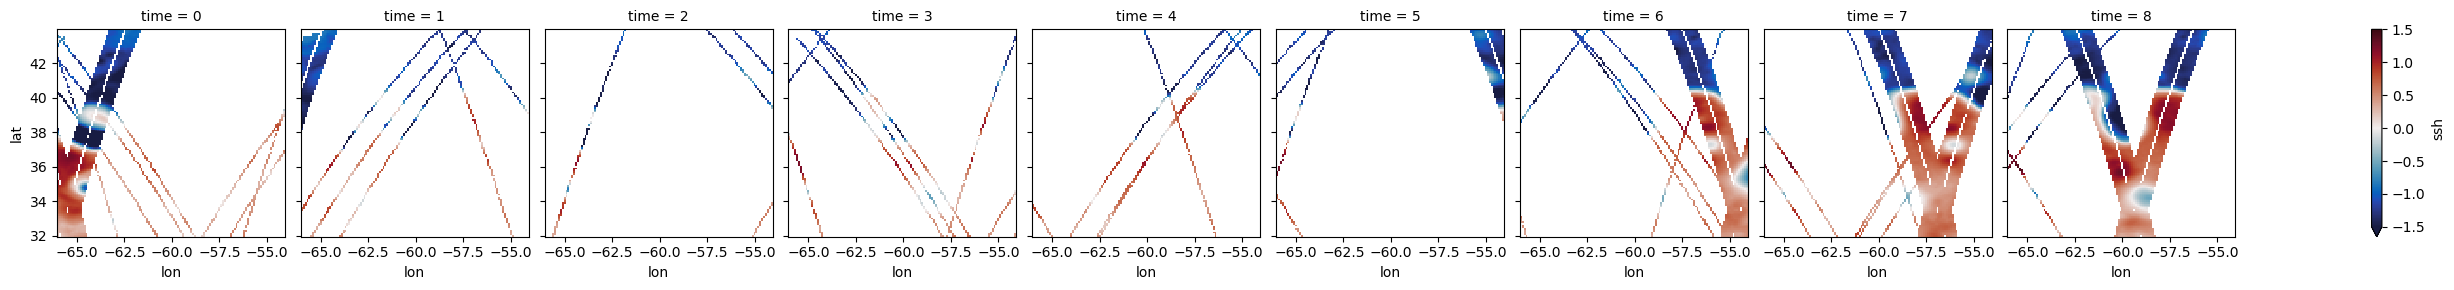

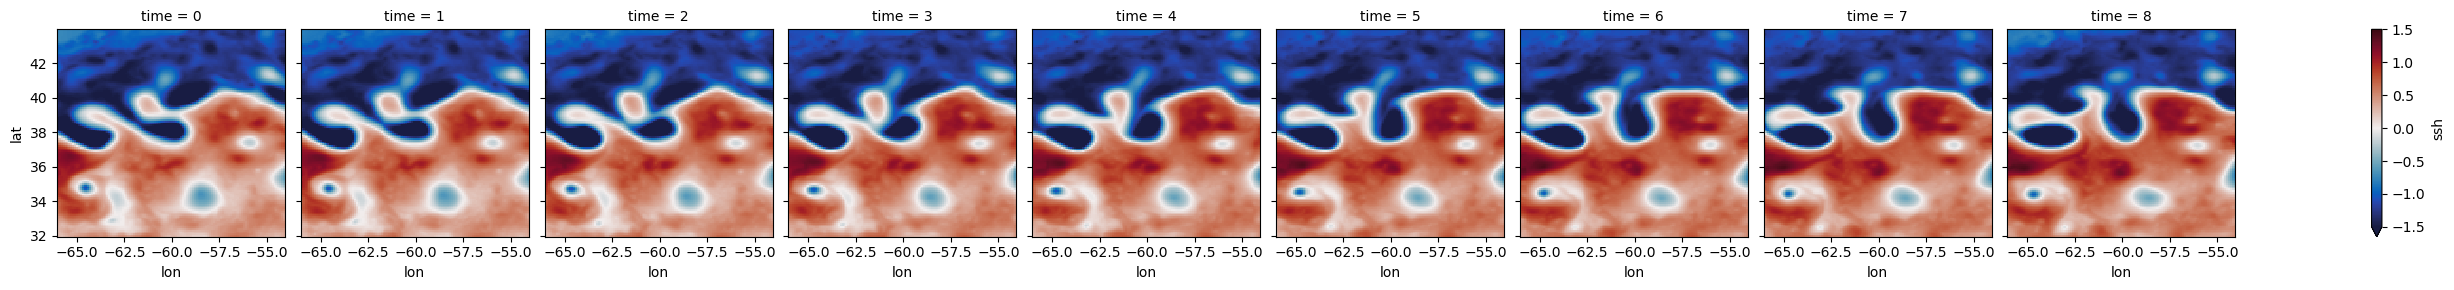

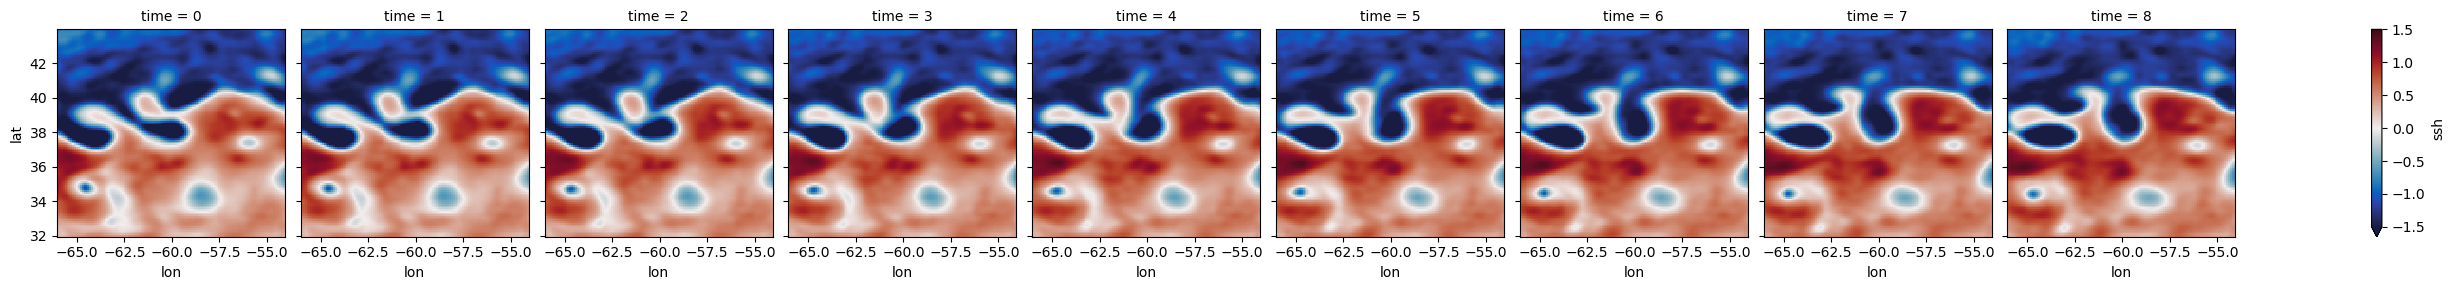

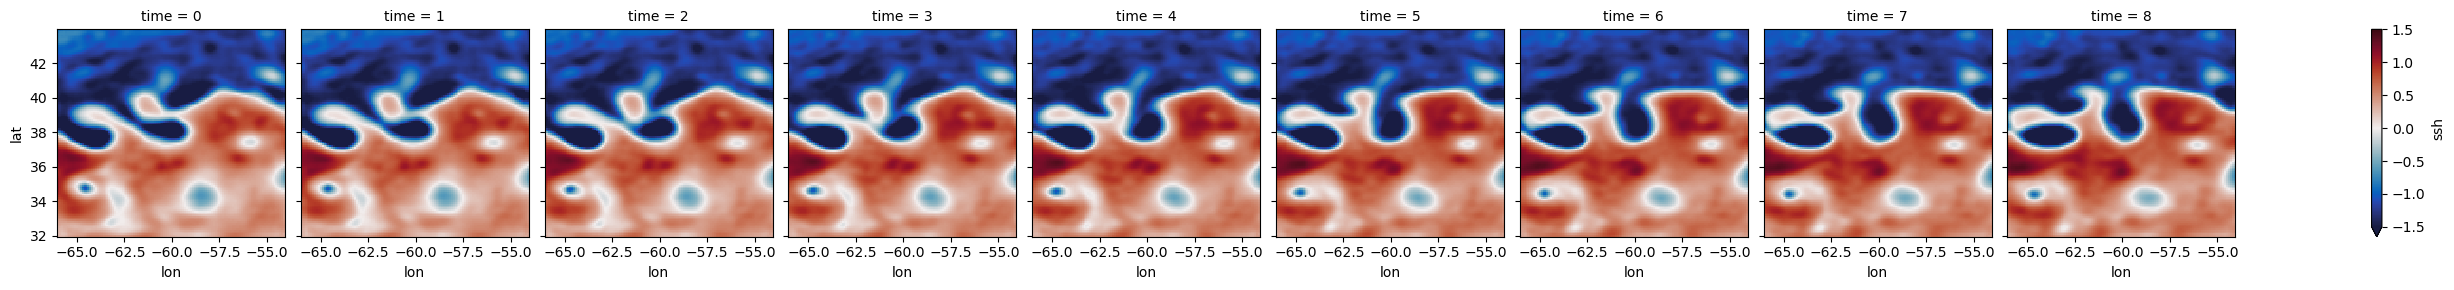

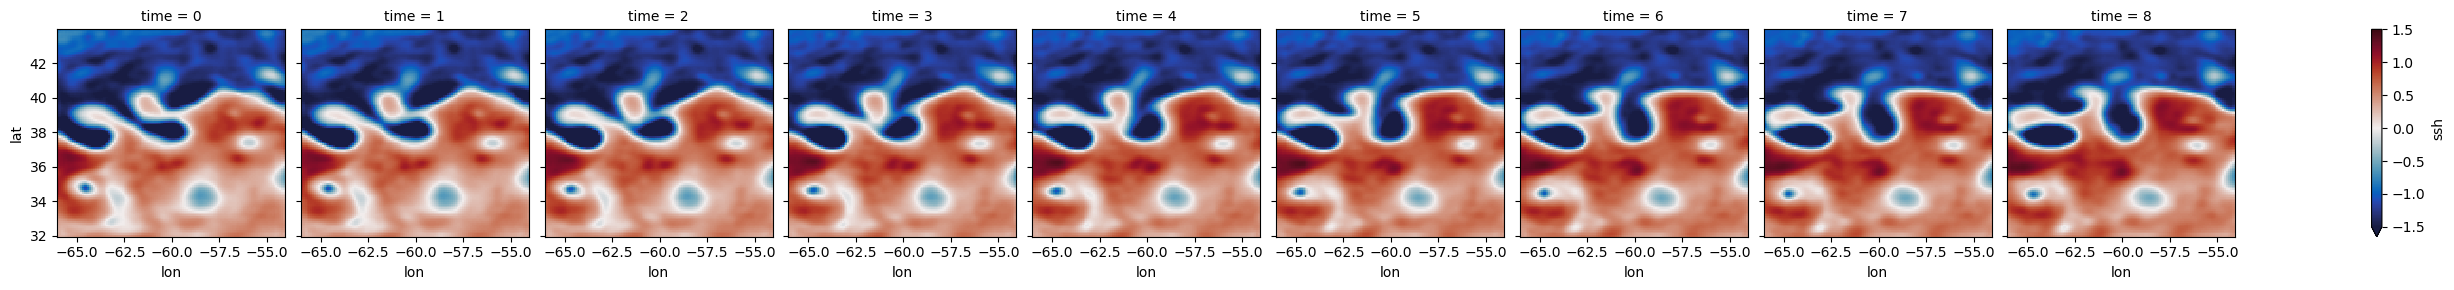

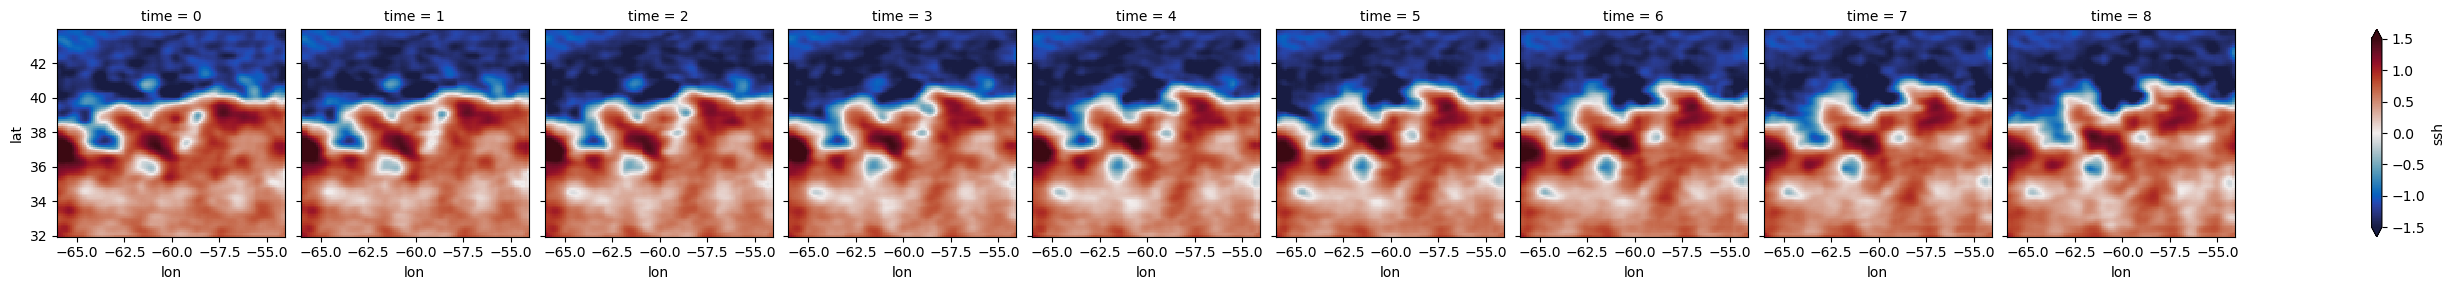

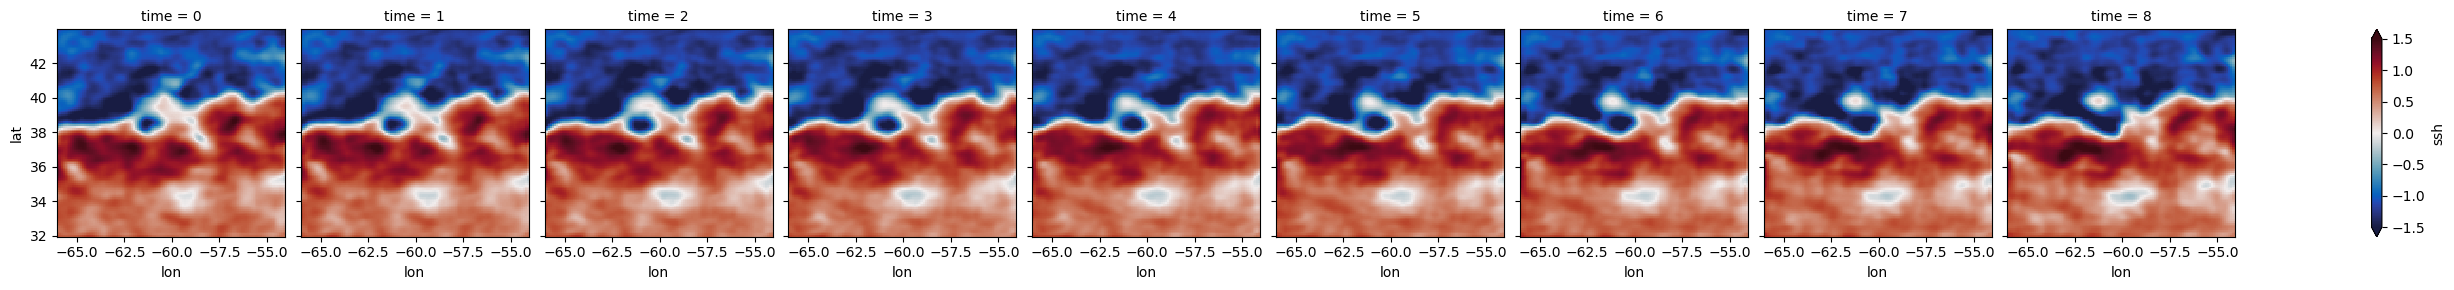

In [28]:
nt = 7

k=10
batch = next(itertools.islice(data_loader, k, None))
y = batch[0].to(device)
x = batch[1].to(device)

import cmocean as cmo
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),y.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

y = y.nan_to_num()

import cmocean as cmo
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

x_hat = ldm(x,diffusion=False)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

x_hat = ldm(x,diffusion=False)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z, mean, log_var = ldm.encoder(x)
x_hat = ldm.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z = torch.Tensor(np.random.normal(size=z.size(), scale=1.0)).to(device)
x_hat = ldm.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z = torch.Tensor(np.random.normal(size=z.size(), scale=1.0)).to(device)
x_hat = ldm.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

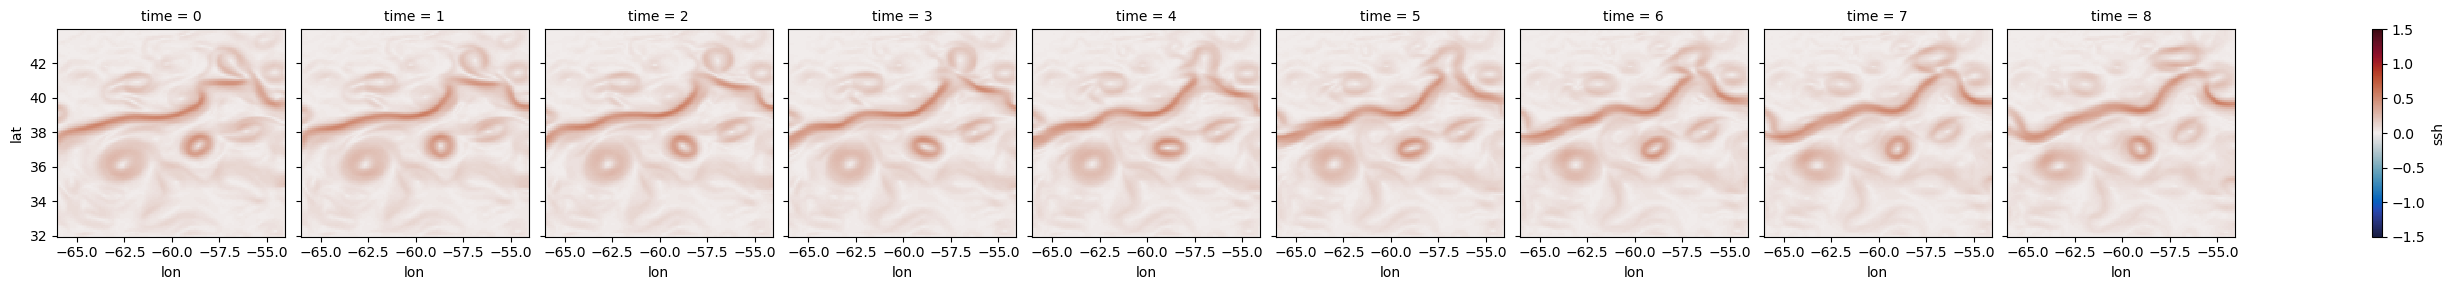

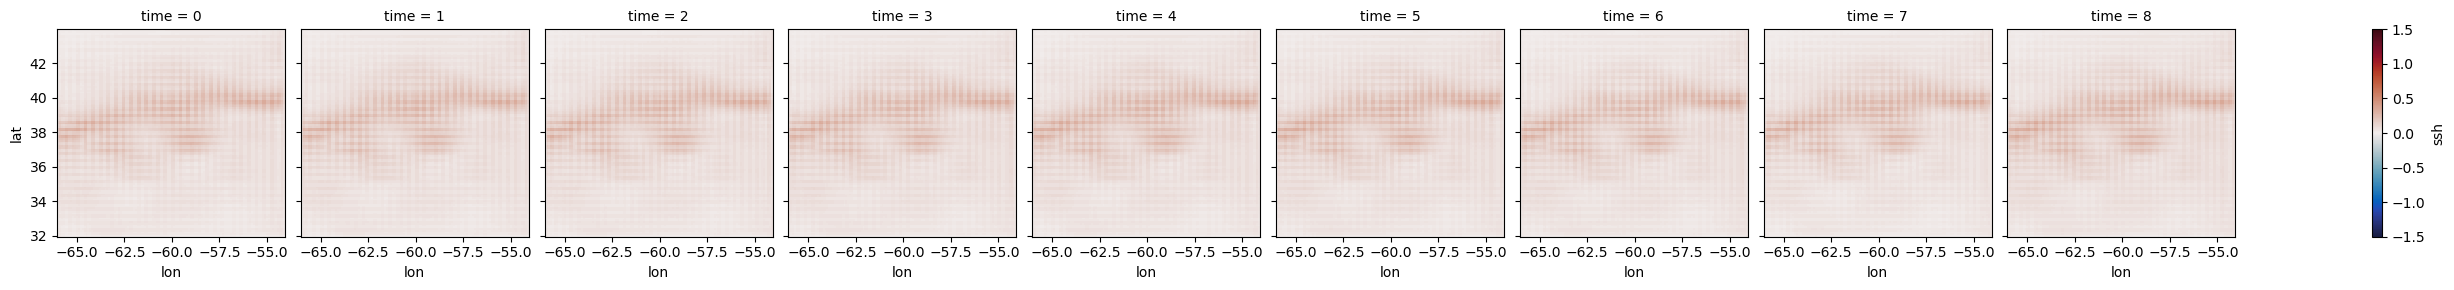

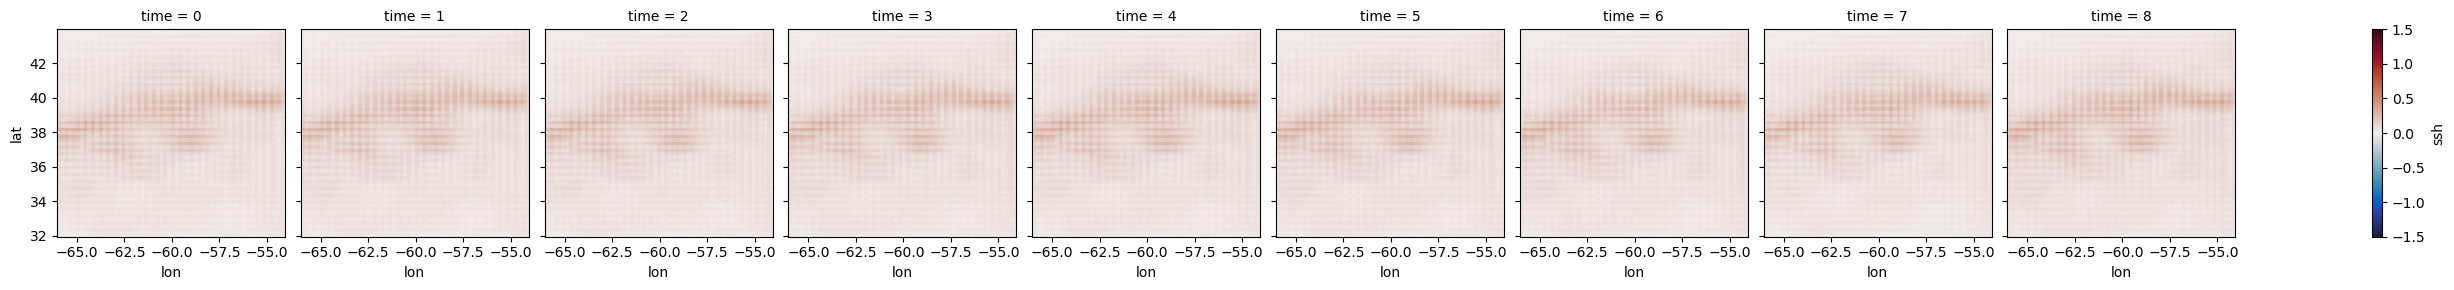

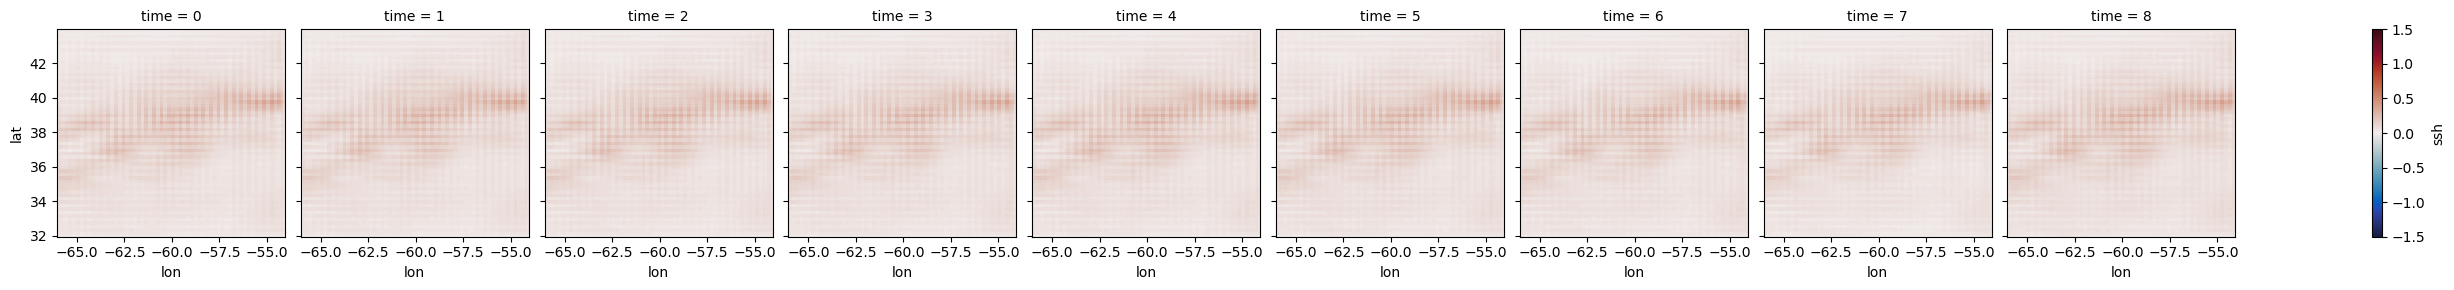

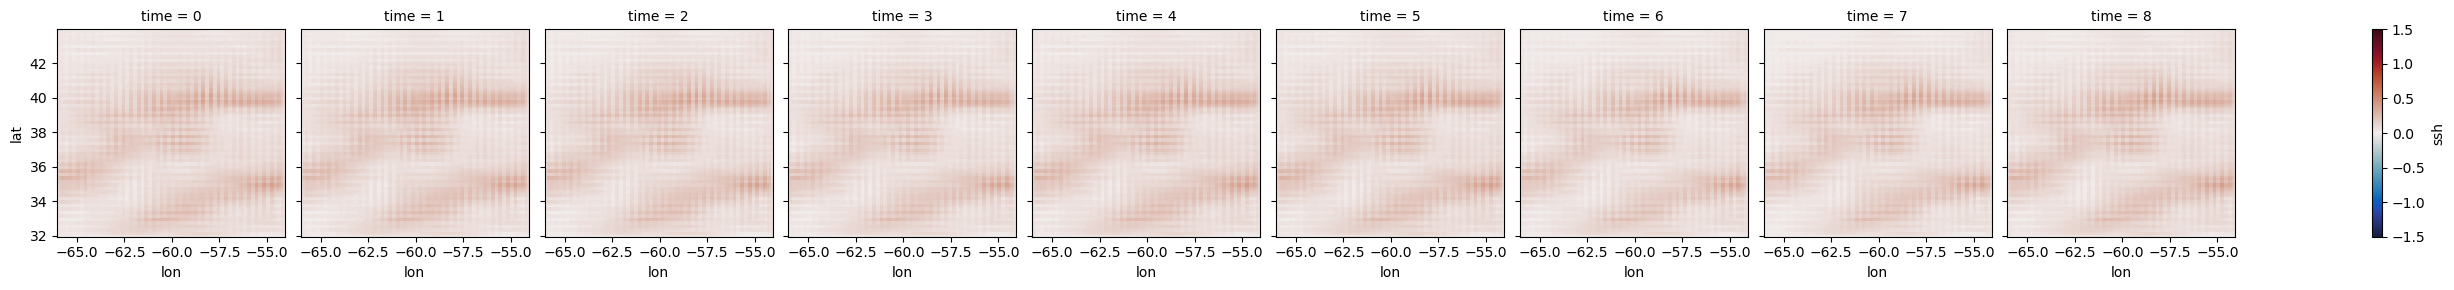

In [33]:
import cmocean as cmo
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z, mean, log_var = ldm.encoder(x)
x_hat = ldm.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z, mean, log_var = ldm.encoder(x)
x_hat = ldm.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z = torch.Tensor(np.random.normal(size=z.size(), scale=1.0)).to(x.device)
x_hat = ldm.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

z = torch.Tensor(np.random.normal(size=z.size(), scale=1.0)).to(x.device)
x_hat = ldm.decoder(z)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_hat.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9,vmin=-1.5,vmax=1.5,cmap=cmo.cm.balance)
plt.show()

/tmp/ipykernel_1469052/2766563016.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1469052/2766563016.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 23.70it/s]


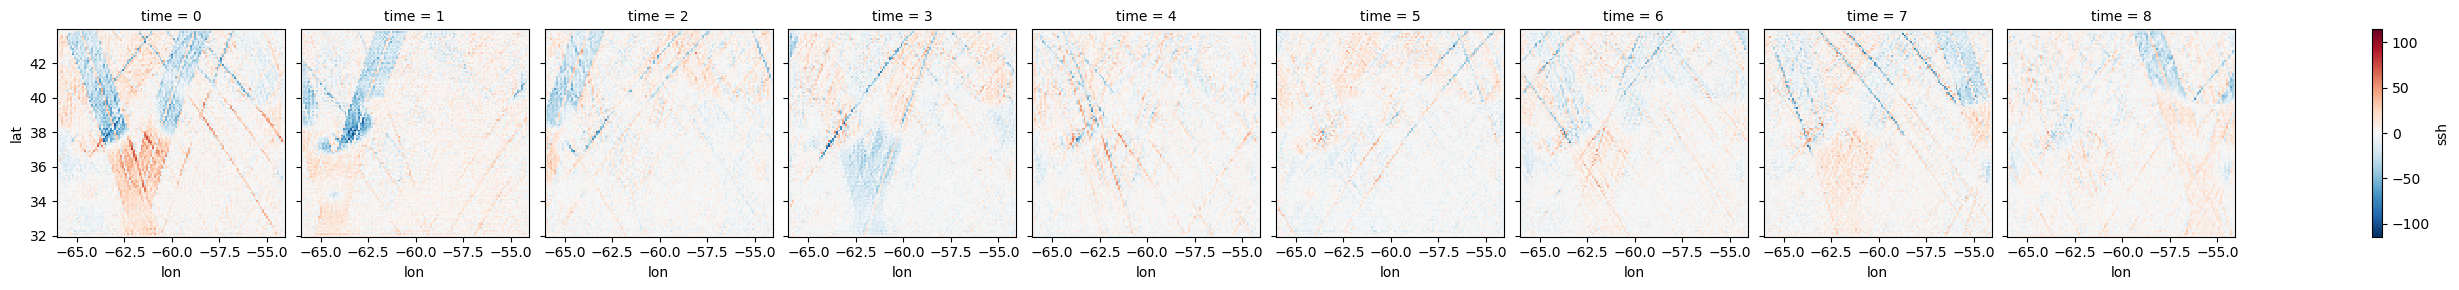

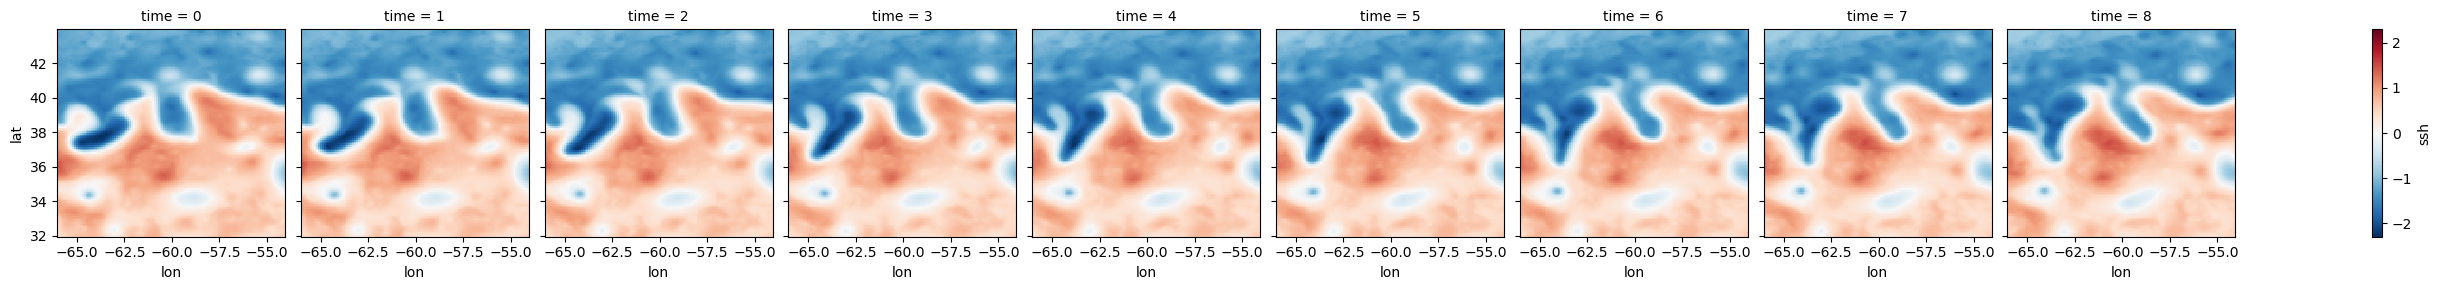

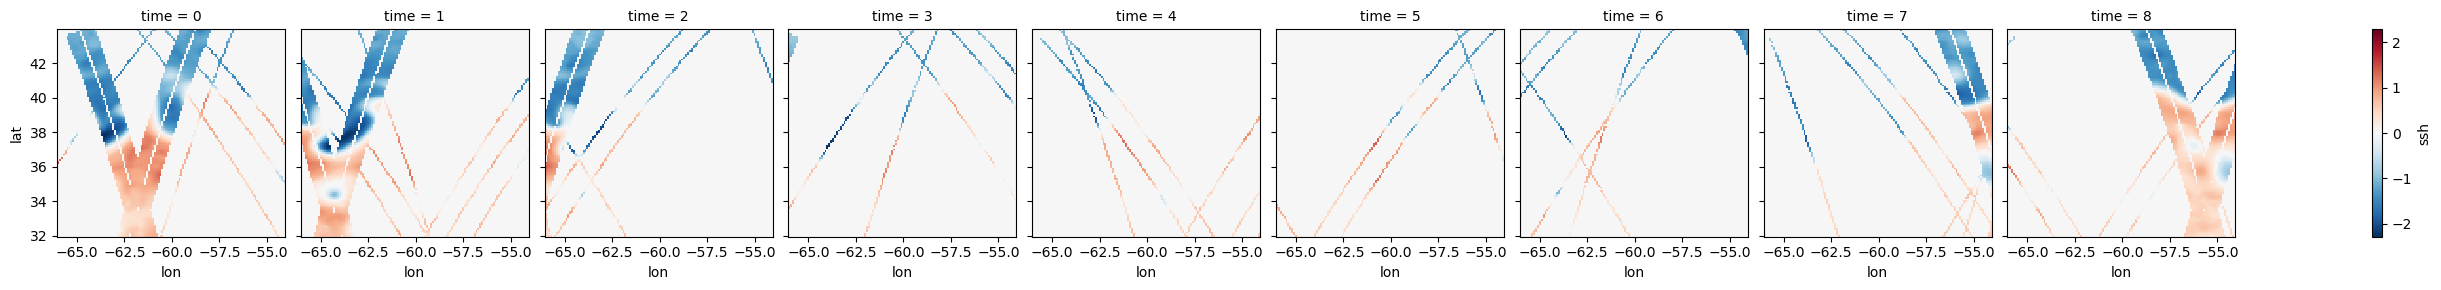

In [54]:
#ckpt = torch.load('ckpt/ckpt.pth', map_location=device)
#score_model.load_state_dict(ckpt)
sample_batch_size = 4 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
x_estim = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  y,
                  batch_size=x.shape[0],
                  num_steps=100,
                  device=device)     
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x_estim.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9)
plt.show()
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),x.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9)
plt.show()
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),y.detach().cpu()[0])},
           coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.plot(col='time',col_wrap=9)
plt.show()

In [50]:
#@title Sampling (double click to expand or collapse)

from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt/ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/tmp/ipykernel_1281400/3053618501.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_1281400/3053618501.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


RuntimeError: shape '[64, 9, 120, 120]' is invalid for input of size 1

## Likelihood Computation

A by-product of the probability flow ODE formulation is likelihood computation. Suppose we have a differentiable one-to-one mapping $\mathbf{h}$ that transforms a data sample $\mathbf{x} \sim p_0$ to a prior distribution $\mathbf{h}(\mathbf{x}) \sim p_T$. We can compute the likelihood of $p_0(\mathbf{x})$ via the following [change-of-variable formula](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function)
\begin{align*}
p_0(\mathbf{x}) = p_T(\mathbf{h}(\mathbf{x})) |\operatorname{det}(J_\mathbf{h}(\mathbf{x}))|,
\end{align*}
where $J_\mathbf{h}(\mathbf{x})$ represents the Jacobian of the mapping $\mathbf{h}$, and we assume it is efficient to evaluate the likelihood of the prior distribution $p_T$.

The trajectories of an ODE also define a one-to-one mapping from $\mathbf{x}(0)$ to $\mathbf{x}(T)$. For ODEs of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt,
\end{align*}
there exists an [instantaneous change-of-variable formula](https://arxiv.org/abs/1806.07366) that connects the probability of $p_0(\mathbf{x})$ and $p_1(\mathbf{x})$, given by
\begin{align*}
p_0 (\mathbf{x}(0)) = e^{\int_0^1 \operatorname{div} \mathbf{f}(\mathbf{x}(t), t) d t} p_1(\mathbf{x}(1)),
\end{align*}
where $\operatorname{div}$ denotes the divergence function (trace of Jacobian).

In practice, this divergence function can be hard to evaluate for general vector-valued function $\mathbf{f}$, but we can use an unbiased estimator, named [Skilling-Hutchinson estimator](http://blog.shakirm.com/2015/09/machine-learning-trick-of-the-day-3-hutchinsons-trick/), to approximate the trace. Let $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. The Skilling-Hutchinson estimator is based on the fact that
\begin{align*}
\operatorname{div} \mathbf{f}(\mathbf{x}) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_\mathbf{f}(\mathbf{x}) \boldsymbol\epsilon].
\end{align*}
Therefore, we can simply sample a random vector $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, and then use $\boldsymbol \epsilon^\intercal J_\mathbf{f}(\mathbf{x}) \boldsymbol \epsilon$ to estimate the divergence of $\mathbf{f}(\mathbf{x})$. This estimator only requires computing the Jacobian-vector product $J_\mathbf{f}(\mathbf{x})\boldsymbol \epsilon$, which is typically efficient.

As a result, for our probability flow ODE, we can compute the (log) data likelihood with the following
\begin{align*}
\log p_0(\mathbf{x}(0)) = \log p_1(\mathbf{x}(1)) -\frac{1}{2}\int_0^1 \frac{d[\sigma^2(t)]}{dt} \operatorname{div} s_\theta(\mathbf{x}(t), t) dt.
\end{align*}
With the Skilling-Hutchinson estimator, we can compute the divergence via
\begin{align*}
\operatorname{div} s_\theta(\mathbf{x}(t), t) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_{s_\theta}(\mathbf{x}(t), t) \boldsymbol\epsilon].
\end{align*}
Afterwards, we can compute the integral with numerical integrators. This gives us an unbiased estimate to the true data likelihood, and we can make it more and more accurate when we run it multiple times and take the average. The numerical integrator requires $\mathbf{x}(t)$ as a function of $t$, which can be obtained by the probability flow ODE sampler.

In [ ]:
#@title Define the likelihood function (double click to expand or collapse)

def prior_likelihood(z, sigma):
  """The likelihood of a Gaussian distribution with mean zero and
      standard deviation sigma."""
  shape = z.shape
  N = np.prod(shape[1:])
  return -N / 2. * torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=(1,2,3)) / (2 * sigma**2)

def ode_likelihood(x,
                   score_model,
                   marginal_prob_std,
                   diffusion_coeff,
                   batch_size=64,
                   device='cuda',
                   eps=1e-5):
  """Compute the likelihood with probability flow ODE.

  Args:
    x: Input data.
    score_model: A PyTorch model representing the score-based model.
    marginal_prob_std: A function that gives the standard deviation of the
      perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the
      forward SDE.
    batch_size: The batch size. Equals to the leading dimension of `x`.
    device: 'cuda' for evaluation on GPUs, and 'cpu' for evaluation on CPUs.
    eps: A `float` number. The smallest time step for numerical stability.

  Returns:
    z: The latent code for `x`.
    bpd: The log-likelihoods in bits/dim.
  """

  # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
  epsilon = torch.randn_like(x)

  def divergence_eval(sample, time_steps, epsilon):
    """Compute the divergence of the score-based model with Skilling-Hutchinson."""
    with torch.enable_grad():
      sample.requires_grad_(True)
      score_e = torch.sum(score_model(sample, time_steps) * epsilon)
      grad_score_e = torch.autograd.grad(score_e, sample)[0]
    return torch.sum(grad_score_e * epsilon, dim=(1, 2, 3))

  shape = x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the score-based model for the black-box ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def divergence_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the divergence of score for the black-box ODE solver."""
    with torch.no_grad():
      # Obtain x(t) by solving the probability flow ODE.
      sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
      time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
      # Compute likelihood.
      div = divergence_eval(sample, time_steps, epsilon)
      return div.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for the black-box solver."""
    time_steps = np.ones((shape[0],)) * t
    sample = x[:-shape[0]]
    logp = x[-shape[0]:]
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    sample_grad = -0.5 * g**2 * score_eval_wrapper(sample, time_steps)
    logp_grad = -0.5 * g**2 * divergence_eval_wrapper(sample, time_steps)
    return np.concatenate([sample_grad, logp_grad], axis=0)

  init = np.concatenate([x.cpu().numpy().reshape((-1,)), np.zeros((shape[0],))], axis=0)
  # Black-box ODE solver
  res = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')
  zp = torch.tensor(res.y[:, -1], device=device)
  z = zp[:-shape[0]].reshape(shape)
  delta_logp = zp[-shape[0]:].reshape(shape[0])
  sigma_max = marginal_prob_std(1.)
  prior_logp = prior_likelihood(z, sigma_max)
  bpd = -(prior_logp + delta_logp) / np.log(2)
  N = np.prod(shape[1:])
  bpd = bpd / N + 8.
  return z, bpd

In [ ]:
#@title Compute likelihood on the dataset (double click to expand or collapse)

batch_size = 32 #@param {'type':'integer'}

dataset = MNIST('.', train=False, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

ckpt = torch.load('ckpt/ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

all_bpds = 0.
all_items = 0
try:
  tqdm_data = tqdm.notebook.tqdm(data_loader)
  for x, _ in tqdm_data:
    x = x.to(device)
    # uniform dequantization
    x = (x * 255. + torch.rand_like(x)) / 256.
    _, bpd = ode_likelihood(x, score_model, marginal_prob_std_fn,
                            diffusion_coeff_fn,
                            x.shape[0], device=device, eps=1e-5)
    all_bpds += bpd.sum()
    all_items += bpd.shape[0]
    tqdm_data.set_description("Average bits/dim: {:5f}".format(all_bpds / all_items))

except KeyboardInterrupt:
  # Remove the error message when interuptted by keyboard or GUI.
  pass


## Further Resources

If you're interested in learning more about score-based generative models, the following papers would be a good start:

* Yang Song, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, and Ben Poole. "[Score-Based Generative Modeling through Stochastic Differential Equations.](https://arxiv.org/pdf/2011.13456.pdf)" International Conference on Learning Representations, 2021.
* Jonathan Ho, Ajay Jain, and Pieter Abbeel. "[Denoising diffusion probabilistic models.](https://arxiv.org/pdf/2006.11239.pdf)" Advances in Neural Information Processing Systems. 2020.
*    Yang Song, and Stefano Ermon. "[Improved Techniques for Training Score-Based Generative Models.](https://arxiv.org/pdf/2006.09011.pdf)" Advances in Neural Information Processing Systems. 2020.
*   Yang Song, and Stefano Ermon. "[Generative modeling by estimating gradients of the data distribution.](https://arxiv.org/pdf/1907.05600.pdf)" Advances in Neural Information Processing Systems. 2019.

